# 1. Imports

In [18]:
import pandas as pd
import numpy as np
from ast import literal_eval as leval
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()
from matplotlib import pyplot as plt

def get_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers = series[(series < fence_low) | (series > fence_high)]
    return outliers

from emoji import UNICODE_EMOJI

def is_emoji(s):
    flags = re.findall(u'[\U0001F1E6-\U0001F1FF]', s)
    if flags:
        return True
    return s in UNICODE_EMOJI

# 2. Get test dataset

In [19]:
reference_text_df = pd.read_csv('text_extraction/reference_html_as_sentences_df.csv')

claim_data_df = pd.read_csv('text_extraction/text_reference_claims_df.csv')

## 2.1. References

In here we have the information about the references, including the reference ids and the text/sentences extracted.

In [20]:
reference_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   reference_id           676 non-null    object 
 1   reference_property_id  676 non-null    object 
 2   reference_datatype     676 non-null    object 
 3   url                    676 non-null    object 
 4   netloc                 676 non-null    object 
 5   netloc_agg             676 non-null    object 
 6   error_msg              676 non-null    object 
 7   code                   676 non-null    int64  
 8   content-type           676 non-null    object 
 9   final_url              676 non-null    object 
 10  reason                 662 non-null    object 
 11  language_crawl         676 non-null    object 
 12  language_crawl_score   676 non-null    float64
 13  sampling_weight_vb     676 non-null    object 
 14  sampling_weight        676 non-null    float64
 15  html  

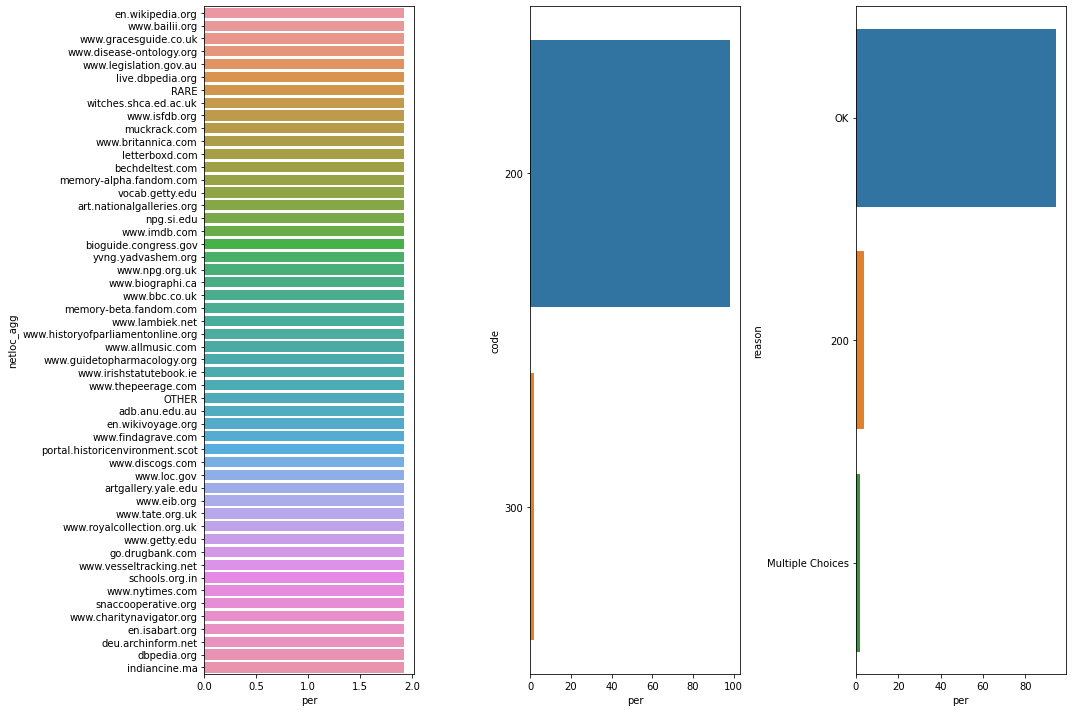

In [4]:
def check_column_dist(df, col):
    counts = df[col].value_counts().reset_index()
    counts.columns = [col, 'counts']
    counts['per'] = 100*counts['counts']/counts['counts'].sum()
    counts[col] = counts[col].astype(str)
    return counts

# Netlocs are equaly spread
# codes are all good
# reasons are good
fig, ax = plt.subplots(1,3,figsize=(15,10))
sns.barplot(data=check_column_dist(reference_text_df, 'netloc_agg'), x='per', y='netloc_agg', ax=ax[0])
sns.barplot(data=check_column_dist(reference_text_df, 'code'), x='per', y='code', ax=ax[1])
sns.barplot(data=check_column_dist(reference_text_df, 'reason'), x='per', y='reason', ax=ax[2])
plt.tight_layout()
plt.show()

## 2.2. Claims

This has all the claim data, including labels, aliases, descriptions, and language IDs.

In [21]:
claim_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   reference_id        1572 non-null   object
 1   entity_id           1572 non-null   object
 2   claim_id            1572 non-null   object
 3   rank                1572 non-null   object
 4   property_id         1572 non-null   object
 5   datatype            1572 non-null   object
 6   datavalue           1572 non-null   object
 7   entity_label        1572 non-null   object
 8   entity_label_lan    1572 non-null   object
 9   property_label      1572 non-null   object
 10  property_label_lan  1572 non-null   object
 11  entity_alias        1572 non-null   object
 12  entity_alias_lan    1572 non-null   object
 13  property_alias      1572 non-null   object
 14  property_alias_lan  1572 non-null   object
 15  entity_desc         1572 non-null   object
 16  entity_desc_lan     1572

In [22]:
print('Total counts:')
print(f'{claim_data_df.claim_id.unique().shape[0]} unique claims')
print(f'{claim_data_df.reference_id.unique().shape[0]} unique references')

Total counts:
1571 unique claims
676 unique references


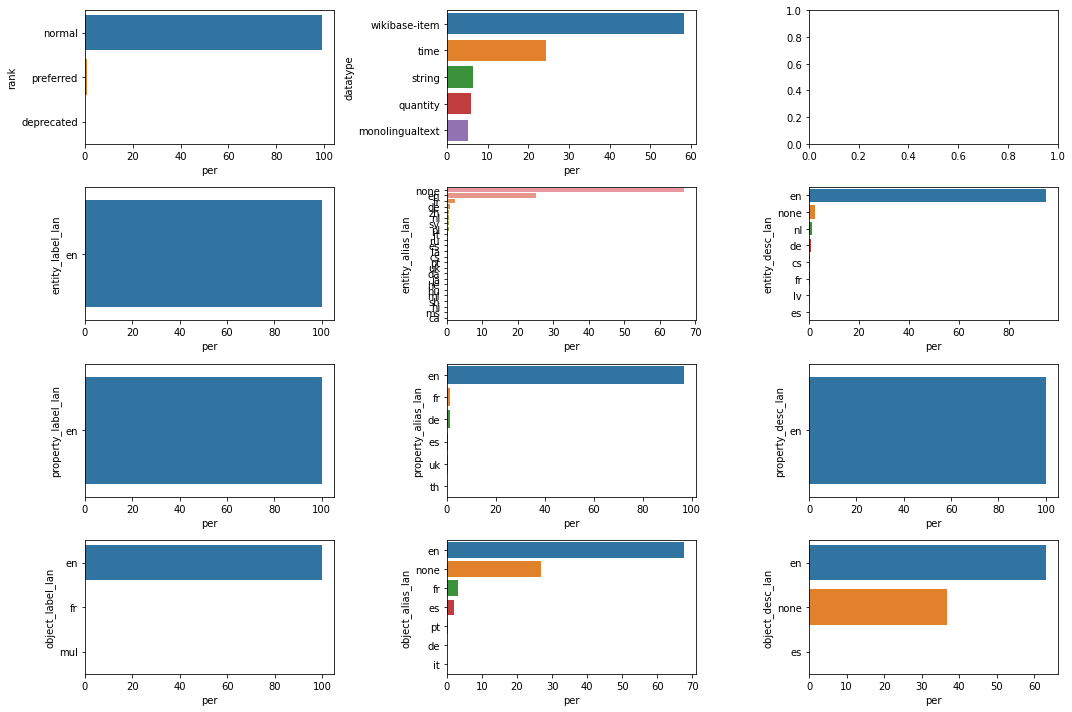

In [15]:
# Considerable amount of aliases for entities, LOTS for properties, reasonable for objects.
# We can use this to generate multiple verbalisations based on aliases.
fig, ax = plt.subplots(4,3,figsize=(15,10))
sns.barplot(data=check_column_dist(claim_data_df, 'rank'), x='per', y='rank', ax=ax[0][0])
sns.barplot(data=check_column_dist(claim_data_df, 'datatype'), x='per', y='datatype', ax=ax[0][1])
#sns.barplot(data=check_column_dist(claim_data_df, 'entity_label_lan'), x='per', y='entity_label_lan', ax=ax[0][2])
sns.barplot(data=check_column_dist(claim_data_df, 'entity_label_lan'), x='per', y='entity_label_lan', ax=ax[1][0])
sns.barplot(data=check_column_dist(claim_data_df, 'entity_alias_lan'), x='per', y='entity_alias_lan', ax=ax[1][1])
sns.barplot(data=check_column_dist(claim_data_df, 'entity_desc_lan'), x='per', y='entity_desc_lan', ax=ax[1][2])
sns.barplot(data=check_column_dist(claim_data_df, 'property_label_lan'), x='per', y='property_label_lan', ax=ax[2][0])
sns.barplot(data=check_column_dist(claim_data_df, 'property_alias_lan'), x='per', y='property_alias_lan', ax=ax[2][1])
sns.barplot(data=check_column_dist(claim_data_df, 'property_desc_lan'), x='per', y='property_desc_lan', ax=ax[2][2])
sns.barplot(data=check_column_dist(claim_data_df, 'object_label_lan'), x='per', y='object_label_lan', ax=ax[3][0])
sns.barplot(data=check_column_dist(claim_data_df, 'object_alias_lan'), x='per', y='object_alias_lan', ax=ax[3][1])
sns.barplot(data=check_column_dist(claim_data_df, 'object_desc_lan'), x='per', y='object_desc_lan', ax=ax[3][2])
plt.tight_layout()
plt.show()

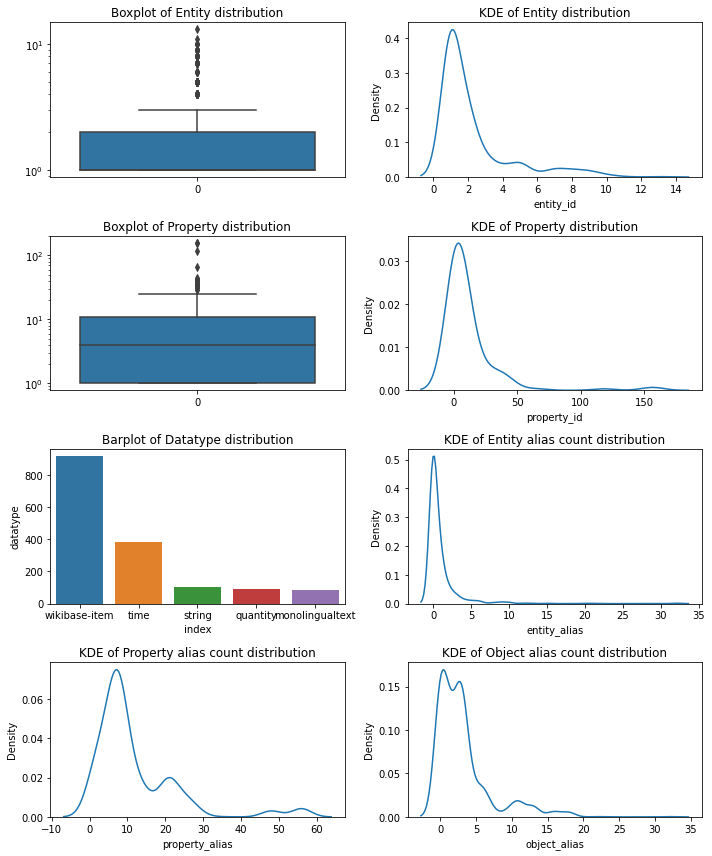

In [8]:
# Distribution of entities and properties involved in the claim data

fig, ax = plt.subplots(4,2,figsize=(10,12))

ax[0][0].set_yscale('log')
entity_count = claim_data_df.entity_id.value_counts()
ax[0][0].set_title('Boxplot of Entity distribution')
sns.boxplot(data = entity_count, ax=ax[0][0])
ax[0][1].set_title('KDE of Entity distribution')
sns.kdeplot(data = entity_count, ax=ax[0][1])

ax[1][0].set_yscale('log')
property_count = claim_data_df.property_id.value_counts()
ax[1][0].set_title('Boxplot of Property distribution')
sns.boxplot(data = property_count, ax=ax[1][0])
ax[1][1].set_title('KDE of Property distribution')
sns.kdeplot(data = property_count, ax=ax[1][1])

datatype_count = claim_data_df.datatype.value_counts().reset_index()
ax[2][0].set_title('Barplot of Datatype distribution')
sns.barplot(data = datatype_count, ax=ax[2][0], x='index', y='datatype')

entity_alias_count = claim_data_df.entity_alias.apply(lambda x : len(leval(x)) if x != 'no-alias' else 0)
ax[2][1].set_title('KDE of Entity alias count distribution')
sns.kdeplot(data = entity_alias_count, ax=ax[2][1])

entity_alias_count = claim_data_df.property_alias.apply(lambda x : len(leval(x)) if x != 'no-alias' else 0)
ax[3][0].set_title('KDE of Property alias count distribution')
sns.kdeplot(data = entity_alias_count, ax=ax[3][0])

entity_alias_count = claim_data_df.object_alias.apply(lambda x : len(leval(x)) if x != 'no-alias' else 0)
ax[3][1].set_title('KDE of Object alias count distribution')
sns.kdeplot(data = entity_alias_count, ax=ax[3][1])

plt.tight_layout()
plt.show()

# We can see that entities and properties are somewhat fairly spread, with most within a lesser volume and a few outliers.
# Datatype has an OK distribution, nothing wrong there for this analysis.
# KDE of alias counts for ent, prop, and obj show most cases on low count and a few outliers.

# 3. Verbalisation

In [9]:
from verbalisation import verbalisation_module

# If updating the module
#from importlib import reload
#reload(verbalisation_module)

verb_module = verbalisation_module.VerbModule()

Graph2Text hparams are: Namespace(logger=True, checkpoint_callback=True, early_stop_callback=False, default_root_dir=None, gradient_clip_val=0, process_position=0, num_nodes=1, num_processes=1, gpus=1, auto_select_gpus=False, log_gpu_memory=None, progress_bar_refresh_rate=1, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=1, max_epochs=100, min_epochs=1, max_steps=None, min_steps=None, limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, val_check_interval=1.0, log_save_interval=100, row_log_interval=50, distributed_backend=None, sync_batchnorm=False, precision=32, weights_summary='top', weights_save_path=None, num_sanity_val_steps=2, truncated_bptt_steps=None, resume_from_checkpoint=None, profiler=None, benchmark=False, deterministic=False, reload_dataloaders_every_epoch=False, auto_lr_find=False, replace_sampler_ddp=True, terminate_on_nan=False, auto_scale_batch_size=False, prepare_data_per_node=True, 

We have added 3 tokens
parameters Namespace(logger=True, checkpoint_callback=True, early_stop_callback=False, default_root_dir=None, gradient_clip_val=0, process_position=0, num_nodes=1, num_processes=1, gpus=1, auto_select_gpus=False, log_gpu_memory=None, progress_bar_refresh_rate=1, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=1, max_epochs=100, min_epochs=1, max_steps=None, min_steps=None, limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, val_check_interval=1.0, log_save_interval=100, row_log_interval=50, distributed_backend=None, sync_batchnorm=False, precision=32, weights_summary='top', weights_save_path=None, num_sanity_val_steps=2, truncated_bptt_steps=None, resume_from_checkpoint=None, profiler=None, benchmark=False, deterministic=False, reload_dataloaders_every_epoch=False, auto_lr_find=False, replace_sampler_ddp=True, terminate_on_nan=False, auto_scale_batch_size=False, prepare_data_per_n

In [10]:
verbs = verb_module.verbalise('translate Graph to English: <H> World Trade Center <R> height <T> 200 meter <H> World Trade Center <R> is a <T> tower')
#print(verbs)
assert verbs == 'The World Trade Center is a tower with a height of 200 meters.'

verbs = verb_module.verbalise({'subject': 'World Trade Center','predicate': 'height','object' : '200 meter'})
#print(verbs)
assert verbs == 'The height of the World Trade Center is 200 meters.'

verbs = verb_module.verbalise([[
        {'subject': 'World Trade Center','predicate': 'is a','object' : 'tower'},
        {'subject': 'World Trade Center','predicate': 'height','object' : '200 meter'}
]])
#print(verbs)
assert verbs == 'The World Trade Center is a tower with a height of 200 meters.'

verbs = verb_module.verbalise([
    {'subject': 'World Trade Center','predicate': 'is a','object' : 'tower'},
    {'subject': 'World Trade Center','predicate': 'height','object' : '200 meter'}
])
#print(verbs)
assert verbs == [
    'The World Trade Center is a tower.',
    'The height of the World Trade Center is 200 meters.'
]

verbs = verb_module.verbalise({'subject': 'Cuhppulčohkka','predicate': 'instance of','object' : 'native label'})
#print(verbs)
assert verbs == 'Cuhppul<unk>ohkka is an instance of a native label.'

verb_module.add_label_to_unk_replacer('Cuhppulčohkka')
sent = verb_module.replace_unks_on_sentence('Cuhppul<unk>ohkka is a native label.', empty_after=True)
#print(verbs)
assert sent == 'Cuhppulčohkka is a native label.'

verb_module.add_label_to_unk_replacer('Cuhppulohkkač')
sent = verb_module.replace_unks_on_sentence('Cuhppulohkka<unk> is a native label.', empty_after=True)
#print(verbs)
assert sent == 'Cuhppulohkkač is a native label.'


verb_module.add_label_to_unk_replacer('🇬🇧')
sent = verb_module.replace_unks_on_sentence('The Value Added Tax Order 2016 applies to jurisdiction of <unk>.', empty_after=True)
#print(verbs)
assert sent == 'The Value Added Tax Order 2016 applies to jurisdiction of 🇬🇧.'

/users/k2031554/.conda/envs/pipeline/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3426: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [23]:
try:
    verbalised_claims_df = pd.read_csv('verbalisation/verbalised_claims_df.csv')
except Exception:
    verbalised_claims_df = None
verbalised_claims_df

,reference_id,entity_id,claim_id,reference_claim_id,rank,property_id,datatype,entity_label,entity_desc,property_label,property_desc,object_label,object_desc,entity_label_is_alias,property_label_is_alias,object_label_is_alias,verbalisation,verbalisation_unks_replaced,verbalisation_unks_replaced_then_dropped
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,place of death,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,False,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
1,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,deathplace,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
2,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,died in,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
3,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,death place,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
4,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,POD,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja is a member of the POD in Kullu Valley.,G V Raja is a member of the POD in Kullu Valley.,G V Raja is a member of the POD in Kullu Valley.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135179,5428d6a275c6601e419c4efeb5788f270af2bf12,Q95125642,Q95125642$40810739-30F2-4A4E-8016-D93D1B4F4DF9,NaN,normal,P20,wikibase-item,Zeev Presman,Victim of the Holocaust,killed in,most specific known (e.g. city instead of coun...,"Lwow, Poland",capital city of Lviv Oblast in western Ukraine,False,True,True,"Zeev Presman was killed in Lwow, Poland.","Zeev Presman was killed in Lwow, Poland.","Zeev Presman was killed in Lwow, Poland."
135180,5428d6a275c6601e419c4efeb5788f270af2bf12,Q95125642,Q95125642$40810739-30F2-4A4E-8016-D93D1B4F4DF9,NaN,normal,P20,wikibase-item,Zeev Presman,Victim of the Holocaust,killed in,most specific known (e.g. city instead of coun...,"Lwów, Poland",capital city of Lviv Oblast in western Ukraine,False,True,True,"Zeev Presman was killed in Lwów, Poland.","Zeev Presman was killed in Lwów, Poland.","Zeev Presman was killed in Lwów, Poland."
135181,5428d6a275c6601e419c4efeb5788f270af2bf12,Q95125642,Q95125642$40810739-30F2-4A4E-8016-D93D1B4F4DF9,NaN,normal,P20,wikibase-item,Zeev Presman,Victim of the Holocaust,killed in,most specific known (e.g. city instead of coun...,"Lviv, Ukraine",capital city of Lviv Oblast in western Ukraine,False,True,True,"Zeev Presman was killed in Lviv, Ukraine.","Zeev Presman was killed in Lviv, Ukraine.","Zeev Presman was killed in Lviv, Ukraine."
135182,5428d6a275c6601e419c4efeb5788f270af2bf12,Q95125642,Q95125642$40810739-30F2-4A4E-8016-D93D1B4F4DF9,NaN,normal,P20,wikibase-item,Zeev Presm

In [15]:
import json
import time

BATCH_SIZE = 16
verbalised_claims_this_batch = []

claim_data_to_keep = [
    'reference_id', 'entity_id', 'claim_id', 'rank', 'property_id', 'datatype',
    'entity_label', 'entity_desc', 'property_label', 'property_desc', 'object_label', 'object_desc'
] # also add entity_label_is_alias, same for property and object

if verbalised_claims_df is not None and not verbalised_claims_df.empty:
    verbalised_claims = json.loads(
        verbalised_claims_df[verbalised_claims_df['verbalisation'] != 'NO_VERBALISATION'].to_json(orient="records")
    )
else:
    verbalised_claims = []

print(len(verbalised_claims))

with open('verbalisation.log','w+',encoding='utf-8') as f:

    for i, row in tqdm(claim_data_df.iterrows(), total=claim_data_df.shape[0]):
    
        try:

            subjects = [row['entity_label']] if row['entity_label_lan'] == 'en' else []
            subjects += leval(row['entity_alias']) if row['entity_alias_lan'] == 'en' else []

            for i_s, subject in enumerate(subjects):

                predicates = [row['property_label']] if row['property_label_lan'] == 'en' else []
                predicates += leval(row['property_alias']) if row['property_alias_lan'] == 'en' else []

                for i_p, predicate in enumerate(predicates):

                    objects = [row['object_label']] if row['object_label_lan'] == 'en' else []
                    objects += leval(row['object_alias']) if row['object_alias_lan'] == 'en' else []

                    for i_o, object_ in enumerate(objects):

                        verbalised_claim_entry = {
                            c : row[c] for c in claim_data_to_keep
                        }                        
                        
                        if type(verbalised_claims_df) == pd.core.frame.DataFrame:
                            if not verbalised_claims_df[
                                (verbalised_claims_df['reference_id'] == row['reference_id']) &\
                                (verbalised_claims_df['claim_id'] == row['claim_id']) &\
                                (verbalised_claims_df['entity_label'] == subject) &\
                                (verbalised_claims_df['object_label'] == object_) &\
                                (verbalised_claims_df['property_label'] == predicate)                        
                            ].empty:
                                continue                        
                        #print('nonempty found:','-'.join([subject, predicate, object_]))

                        verbalised_claim_entry.update({
                            'entity_label_is_alias': (i_s != 0),
                            'property_label_is_alias': (i_p != 0),
                            'object_label_is_alias': (i_o != 0),
                            'entity_label': subject,
                            'property_label': predicate,
                            'object_label': object_
                        })
                        
                        is_last =\
                            (i == claim_data_df.shape[0]-1) &\
                            (i_s == len(subjects)-1) &\
                            (i_p == len(predicates)-1) &\
                            (i_o == len(objects)-1)
                            
                        
                        verbalised_claims_this_batch.append(verbalised_claim_entry)
                        if len(verbalised_claims_this_batch) >= BATCH_SIZE or is_last:
                            #print('verbalising...')
                            verbalisation_inputs = [{
                                'subject':e['entity_label'], 'predicate':e['property_label'], 'object':e['object_label']
                            } for e in verbalised_claims_this_batch]

                            try:
                                verbalisations = verb_module.verbalise(verbalisation_inputs)
                                #f.write(
                                #    f'Verbalising: {[(v["reference_id"], v['claim_id']) for v in verbalised_claims_this_batch]}\n'
                                #)
                            except Exception:
                                print('ERROR VERBALISING:', verbalisation_inputs, sep='\n')
                                raise            

                            for i in range(len(verbalised_claims_this_batch)):
                                try:
                                    verb_module.add_label_to_unk_replacer(verbalised_claims_this_batch[i]['entity_label'])
                                    verb_module.add_label_to_unk_replacer(verbalised_claims_this_batch[i]['object_label'])
                                    verbalised_claims_this_batch[i].update({
                                        'verbalisation' : verbalisations[i],
                                        'verbalisation_unks_replaced': verb_module.replace_unks_on_sentence(
                                            verbalisations[i], empty_after=True
                                        )
                                    })
                                except Exception:
                                    print('REPLACING_ERROR on', verbalised_claims_this_batch[i])
                                    verbalised_claims_this_batch[i].update({
                                        'verbalisation' : verbalisations[i],
                                        'verbalisation_unks_replaced': 'REPLACING_ERROR'
                                    })

                            verbalised_claims += verbalised_claims_this_batch
                            verbalised_claims_this_batch = []

        except Exception:
            print(row)
            #pprint(verbalised_claims_this_row)
            raise

# Load 
verbalised_claims_df = pd.DataFrame(verbalised_claims)

135172


  0%|          | 0/1572 [00:00<?, ?it/s]

nonempty found: Zeev Presman-death location-Lemberg, Poland
nonempty found: Zeev Presman-death location-Lwow, Poland
nonempty found: Zeev Presman-death location-Lwów, Poland
nonempty found: Zeev Presman-death location-Lviv, Ukraine
nonempty found: Zeev Presman-death location-Lvov, Soviet Union
nonempty found: Zeev Presman-death location-Lvov, Russian Empire
nonempty found: Zeev Presman-killed in-Lemberg, Poland
nonempty found: Zeev Presman-killed in-Lwow, Poland
nonempty found: Zeev Presman-killed in-Lwów, Poland
nonempty found: Zeev Presman-killed in-Lviv, Ukraine
nonempty found: Zeev Presman-killed in-Lvov, Soviet Union
nonempty found: Zeev Presman-killed in-Lvov, Russian Empire
verbalising...


/users/k2031554/.conda/envs/pipeline/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3426: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [17]:
import re

# REMOVING REMAINING <UNK> TOKENS
verbalised_claims_df['verbalisation_unks_replaced_then_dropped'] = None
for i, row in tqdm(verbalised_claims_df.iterrows(), total=verbalised_claims_df.shape[0]):
    s = row['verbalisation_unks_replaced']
    # Removing remaining <unk> tokens
    s = re.sub('<unk>', '', s)
    # Removing doublespaces
    s = re.sub(r'\s+', ' ', s).strip()
    # Removing spaces before punctuation
    s = re.sub(r'\s([?.!",](?:\s|$))', r'\1', s)
    
    verbalised_claims_df.loc[i, 'verbalisation_unks_replaced_then_dropped'] = s

  0%|          | 0/135184 [00:00<?, ?it/s]

In [16]:
# Checking if every combination of ENGLISH label+alias for (s,p,o) tuples has been covered
# NO OUTPUTS = ALL OK

claims_list = verbalised_claims_df.claim_id.unique().tolist()
for c_id in claims_list:
    row = claim_data_df[claim_data_df['claim_id'] == c_id]
    matching_claims = row.shape[0]
    verbalised_n_rows = verbalised_claims_df[verbalised_claims_df.claim_id == c_id].shape[0]
    
    verbalised_n_rows_target =\
        ((len(leval(row['entity_alias'].values[0])) if row['entity_alias_lan'].iloc[0] == 'en' else 0) +1) * \
        ((len(leval(row['property_alias'].values[0])) if row['property_alias_lan'].iloc[0] == 'en' else 0) +1) * \
        ((len(leval(row['object_alias'].values[0])) if row['object_alias_lan'].iloc[0] == 'en' else 0) +1)
    
    try:
        assert verbalised_n_rows == verbalised_n_rows_target * matching_claims
    except AssertionError:
        print('Match Error:',c_id)
        print( row.index.values,
            verbalised_n_rows, 'out of', verbalised_n_rows_target * matching_claims,
            f'{verbalised_n_rows_target * matching_claims - verbalised_n_rows} to go')

In [18]:
verbalised_claims_df.to_csv('verbalisation/verbalised_claims_df.csv', index=None)

## Verbalised data CORRECTION and analysis

In [24]:
verbalised_claims_df = pd.read_csv('verbalisation/verbalised_claims_df.csv')
verbalised_claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135184 entries, 0 to 135183
Data columns (total 19 columns):
 #   Column                                    Non-Null Count   Dtype 
---  ------                                    --------------   ----- 
 0   reference_id                              135184 non-null  object
 1   entity_id                                 135184 non-null  object
 2   claim_id                                  135184 non-null  object
 3   reference_claim_id                        135044 non-null  object
 4   rank                                      135184 non-null  object
 5   property_id                               135184 non-null  object
 6   datatype                                  135184 non-null  object
 7   entity_label                              135184 non-null  object
 8   entity_desc                               135184 non-null  object
 9   property_label                            135184 non-null  object
 10  property_desc                   

In [25]:
verbalised_claims_df.head()

,reference_id,entity_id,claim_id,reference_claim_id,rank,property_id,datatype,entity_label,entity_desc,property_label,property_desc,object_label,object_desc,entity_label_is_alias,property_label_is_alias,object_label_is_alias,verbalisation,verbalisation_unks_replaced,verbalisation_unks_replaced_then_dropped
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,place of death,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,False,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
1,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,deathplace,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
2,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,died in,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
3,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,death place,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
4,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,POD,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja is a member of the POD in Kullu Valley.,G V Raja is a member of the POD in Kullu Valley.,G V Raja is a member of the POD in Kullu Valley.


In [65]:
# Define property aliases to use as main verbalisations
special_properties = {
    'P1031': 'citation',
    'P106': 'profession',
    'P1066': 'apprentice of',
    'P1196': 'nature of death',
    'P1308': 'position holder',
    'P131': 'is located in',
    'P1346': 'won by',
    'P136': {#dict replaces if the key is either in the entity label or the object label
        'film': 'film genre', # Manually replace here, as 'genre of' would be good but is not there
        '': 'genre' #default
    },
    'P1435': 'designation', # Manually replace the Overhailes case
    'P1441': 'featured in work',
    'P1448': 'name',
    'P1476': 'titled',
    'P1542': 'causes',
    'P1559': 'native name',
    'P166' : {
        'Doctor': 'recognition title',
        '': 'award received'
    },
    'P17': {
        'trial': 'host country',
        '': 'land'# Manually correct cases where food is introduced (Gups Ponmala)
    },
    'P186': 'made from',
    'P189': 'found in',
    'P195': 'art collection',#Manually correct cases due to extensive entity label formatting
    'P2017': 'isomeric SMILES', #this is the main label, this is just to remind myself to manually correct them due to extensive label format
    'P21': 'gender',
    'P233': 'SMILES', #Manually correct cases due to extensive entity label formatting
    'P26': 'marry', #Manually correct some cases due to tense
    'P279': 'is a type of',
    'P2896': 'publication frequency',#Manually correct cases due to missing link between 1 week = weekly expressions.
    'P31': 'is a',
    'P3373': 'is sibling of',
    'P364': 'original language',
    'P39' : 'held position',
    'P40' : 'has child',
    'P451' : 'is partner of',
    'P452' : 'sector',#Manually correct line of credit cases
    'P485': 'archive location',
    'P5021': 'assessment', #Manually correct inversion cases
    'P527': 'parts',
    'P551': 'resided in',
    'P571': 'created',
    'P580': 'starting',
    'P582': 'ending',
    'P607': 'in conflict',
    'P674': 'characters', #Manually correct cases here
    'P725': 'voice actor', #Manually correct cases here
    'P734': 'last name',
    'P735': 'first name',
    'P780': 'symptoms',
    'P793': 'event',
    'P802': 'students',
    #'P8045' Manually correct this one
    'P915': 'filmed at',
    'P921': 'about',
    'P97': 'hereditary title'
}

verbalised_claims_df['is_main_verbalisation'] = None
verbalised_claims_df['alternative_alias_used'] = None

for i, row in verbalised_claims_df.iterrows():
    # If a special property (to be replaced by alias), do a custom logic where
    # an official property_label is elected instead
    if row['property_id'] in special_properties.keys():   
        verbalised_claims_df.loc[i, 'alternative_alias_used'] = True
        preferred_property_label = special_properties[row['property_id']]
        if type(preferred_property_label) == str:
            # if the new label is str, just flag as main verbalisation in case the entity/object are main labels
            # and the property label is the new official label
            if not row['entity_label_is_alias'] and\
                row['property_label'] == preferred_property_label and\
                not row['object_label_is_alias']:
                
                verbalised_claims_df.loc[i, 'is_main_verbalisation'] = True
            else:
                verbalised_claims_df.loc[i, 'is_main_verbalisation'] = False
        elif type(preferred_property_label) == dict:
            # if it's a dict, elect as new official label only if either entity or object labels contain
            # the key, and select the property label that is its value
            # if one is identified this way, skip the rest
            # we start with it not being a main verbalisation until we find a key that matches
            verbalised_claims_df.loc[i, 'is_main_verbalisation'] = False
            
            # check if another row with the same claim id and reference id is 
            # not already the main verbalisation
            if verbalised_claims_df[
                (verbalised_claims_df['claim_id'] == row['claim_id']) &\
                (verbalised_claims_df['reference_id'] == row['reference_id'])
            ].is_main_verbalisation.sum() > 0:
                continue
                
            for key in preferred_property_label.keys():
                if key in row['entity_label'] or key in row['object_label']:
                    if not row['entity_label_is_alias'] and\
                        row['property_label'] == preferred_property_label[key] and\
                        not row['object_label_is_alias']:
                        #print(row)
                        verbalised_claims_df.loc[i, 'is_main_verbalisation'] = True
                        if key=='':                            
                            verbalised_claims_df.loc[i, 'alternative_alias_used'] = False
                        break #stop iterating over keys of preferred_property_label
                
                
    # Else, or if we fail to find an official property_label through the logic above,
    # just check if all X_is_alias columns are false
    else:        
        verbalised_claims_df.loc[i, 'alternative_alias_used'] = False
        if not row['entity_label_is_alias'] and\
            not row['property_label_is_alias'] and\
            not row['object_label_is_alias']:

            verbalised_claims_df.loc[i, 'is_main_verbalisation'] = True
        else:
            verbalised_claims_df.loc[i, 'is_main_verbalisation'] = False


In [66]:
assert verbalised_claims_df['is_main_verbalisation'].value_counts()[True] == 1570
#1570 is the total of unique ref_claim pairs
assert verbalised_claims_df['is_main_verbalisation'].isna().sum() == 0
assert verbalised_claims_df['alternative_alias_used'].isna().sum() == 0
# no empty cells

In [67]:
print('Total verbalised counts:')
print(f'{verbalised_claims_df.claim_id.unique().shape[0]} unique claims')
print(f'{verbalised_claims_df.reference_id.unique().shape[0]} unique references')

Total verbalised counts:
1569 unique claims
676 unique references


In [68]:
# 
n_unk_replacements = verbalised_claims_df[verbalised_claims_df['verbalisation'].apply(lambda x : '<unk>' in x)].shape[0]
print(
    f"Unk replacement was needed in {n_unk_replacements} ({100*n_unk_replacements/verbalised_claims_df.shape[0]}%) of verbalisations"
)

n_unk_replacements_solved = verbalised_claims_df[verbalised_claims_df['verbalisation_unks_replaced'].apply(lambda x : '<unk>' in x)].shape[0]
print(
    f"Unk replacement was NOT solved in {n_unk_replacements_solved} ({100*n_unk_replacements_solved/n_unk_replacements}%) of cases"
)

Unk replacement was needed in 3486 (2.5787075393537697%) of verbalisations
Unk replacement was NOT solved in 206 (5.909351692484223%) of cases


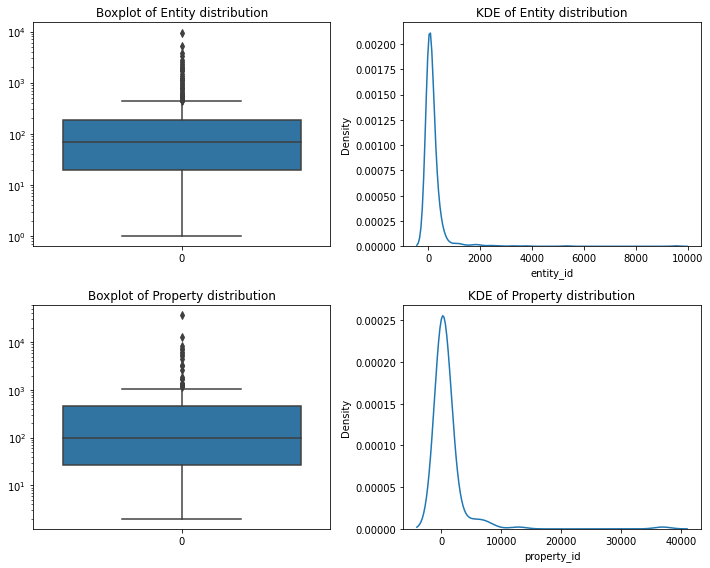

In [69]:
# Distribution of entities and properties involved in the verbalisations

fig, ax = plt.subplots(2,2,figsize=(10,8))

ax[0][0].set_yscale('log')
entity_count = verbalised_claims_df.entity_id.value_counts()
ax[0][0].set_title('Boxplot of Entity distribution')
sns.boxplot(data = entity_count, ax=ax[0][0])
ax[0][1].set_title('KDE of Entity distribution')
sns.kdeplot(data = entity_count, ax=ax[0][1])

ax[1][0].set_yscale('log')
property_count = verbalised_claims_df.property_id.value_counts()
ax[1][0].set_title('Boxplot of Property distribution')
sns.boxplot(data = property_count, ax=ax[1][0])
ax[1][1].set_title('KDE of Property distribution')
sns.kdeplot(data = property_count, ax=ax[1][1])

plt.tight_layout()
plt.show()

# Half of both entities and properties show up between 50 and 200/500 times,
# the majority being between 1 and 1000. A few outliers are beyond that.

# Entities/Properties that are over-represented here are due to having too many aliases.

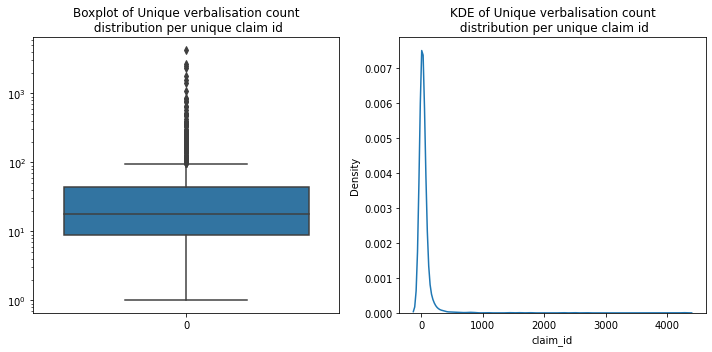

,claim_id,count
0,Q413762$C5D101E9-E57F-4EA3-8D7B-C6C08BEEF3E3,4267
1,Q411646$985DD31A-14E7-4BD1-A920-C57D7591F21D,2670
2,q413762$9C2AD3C8-99A3-49F6-A2DA-67EA8FD7680A,2482
3,Q683861$C89C357A-46F6-4407-A921-9D3E8869513D,2296
4,Q154869$F69C6AB9-0A67-41CF-BBE9-1A12E1EB744B,1759
...,...,...
146,Q78206048$bc14514e-4617-426e-b800-5ccb0c3a3420,98
147,Q58480336$53D2AD06-4343-4CB0-9332-3CA0D1AC2A33,98
148,Q100328935$ca971e29-ea7a-4c2b-9df6-b6f79c662966,98
149,Q59279451$E2B1DA8D-6397-4FE0-874C-7F642DAA671D,97


In [70]:
unique_verbalisation_counts = verbalised_claims_df[['claim_id', 'verbalisation_unks_replaced_then_dropped']].\
    drop_duplicates().claim_id.value_counts()

# Distribution of entities and properties involved in the verbalisations

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_yscale('log')
ax[0].set_title('Boxplot of Unique verbalisation count\n distribution per unique claim id')
sns.boxplot(data = unique_verbalisation_counts, ax=ax[0])
ax[1].set_title('KDE of Unique verbalisation count\n distribution per unique claim id')
sns.kdeplot(data = unique_verbalisation_counts, ax=ax[1])

plt.tight_layout()
plt.show()

# This shows the majority of claims have up to 100 unique verbalisations due to aliases, with some having way more.
# The biggest one, for instance, has 33 subject aliases, 22 predicate aliases, and 8 object aliases

get_outliers(unique_verbalisation_counts).reset_index().rename({'index':'claim_id','claim_id':'count'}, axis=1)

In [71]:
# Next step is manually correcting some verbalisations before SENTENCE SELECTION
#Create a 'corrected_verbalisation' and a 'is_corrected_verbalisation' for manual annotation before sentence selection
verbalised_claims_df_main = verbalised_claims_df[verbalised_claims_df['is_main_verbalisation'] == True]\
    .reset_index(drop=True).drop('is_main_verbalisation', axis=1).copy()

verbalised_claims_df_main['corrected_verbalisation'] = verbalised_claims_df_main['verbalisation_unks_replaced_then_dropped']
verbalised_claims_df_main['is_corrected_verbalisation'] = False

verbalised_claims_df_main.to_csv('verbalisation/verbalised_claims_df_main.csv', index=None)

In [72]:
print('Percentage of main verbalisations where an alias was used for better verbalisation')
print(100*verbalised_claims_df_main['alternative_alias_used'].sum()/verbalised_claims_df_main.shape[0])
# Percentage of main verbalisations where an alias was used for better verbalisation

Percentage of main verbalisations where an alias was used for better verbalisation
49.36305732484077


Now, we manually go over the verbalisations and correct those that need correcting, marking `is_corrected_verbalisation` as true.

Percentage of main verbalisations where a manual correction was used.
8.9171974522293
Distribution of normalised levenshtein distance after corrections.
count    140.000000
mean       0.219580
std        0.219633
min        0.007692
25%        0.053571
50%        0.163333
75%        0.245965
max        0.921053
dtype: float64


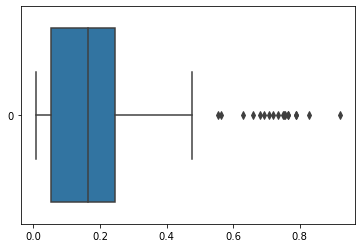

In [29]:
from Levenshtein import distance as levenshtein_distance

verbalised_claims_df_main = pd.read_csv('verbalisation/verbalised_claims_df_main.csv')
verbalised_claims_df_main_corrected = pd.read_csv('verbalisation/verbalised_claims_df_main_corrected.csv')

# is_corrected_verbalisation has NOT been filled during correction, as this is quicker and less error-prone
verbalised_claims_df_main_corrected['is_corrected_verbalisation'] = verbalised_claims_df_main_corrected.apply(
    lambda row : row['corrected_verbalisation'] != row['verbalisation_unks_replaced_then_dropped'], axis=1
)

print('Percentage of main verbalisations where a manual correction was used.')
print(100*verbalised_claims_df_main_corrected['is_corrected_verbalisation'].sum()/verbalised_claims_df_main.shape[0])

norm_levenshtein_distances = verbalised_claims_df_main_corrected.apply(
    lambda row : levenshtein_distance(
        row['corrected_verbalisation'],
        row['verbalisation_unks_replaced_then_dropped']
    )/max(
        len(row['corrected_verbalisation']),
        len(row['verbalisation_unks_replaced_then_dropped'])
    ),
    axis=1
)
norm_levenshtein_distances = norm_levenshtein_distances[norm_levenshtein_distances>0].reset_index(drop=True)
sns.boxplot(data=norm_levenshtein_distances, orient='h')
print('Distribution of normalised levenshtein distance after corrections.')
print(norm_levenshtein_distances.describe())

In [30]:
# REMOVE P1448 (OFFICIAL NAME), P1476 (TITLE), AND P1889 (DIFFERENT) AS THEY ARE REDUNDANT AND NON-INFORMATIVE
#also look at the dataset creation for other properties that were deleted and delete them too

BAD_PROPERTIES = [
    'P1448', # offical name
    'P1476', # title
    'P1889',# different
    'P31', # - instance of
    'P279',# - subclass of
    'P373',# - commons category
    'P910',# - Topic's main category
    'P7561',# - category for the interior of the item
    'P5008',# - on focus list of Wikimedia project
    'P2670',# -  has parts of the class
    'P1740',# -  category for films shot at this location
    'P1612',# -  Commons Institution page
    'P8989',# -  category for the view of the item
    'P2959',# -  permanent duplicated item
    'P7867',# -  category for maps
    'P935' ,# -  Commons gallery
    'P1472',#  -  Commons Creator page
    'P8596',# category for the exterior of the item
    'P5105',# Deutsche Bahn station category
    'P8933',# category for the view from the item
    'P642',# of
    'P3876',# category for alumni of educational institution
    'P1791',# category of people buried here
    'P7084',# related category
    'P1465',# category for people who died here
    'P1687',# Wikidata property
    'P6104',# maintained by WikiProject
    'P4195',# category for employees of the organization
    'P1792',# category of associated people
    'P5869',# model item
    'P1659',# see also
    'P1464',# category for people born here
    'P2354',# has list
    'P1424',# topic's main template
    'P7782',# category for ship name
    'P179',# part of the series
    'P7888',# merged into
    'P6365',# member category
    'P8464',# content partnership category
    'P360',# is a list of
    'P805',# statement is subject of
    'P8703',# entry in abbreviations table
    'P1456',# list of monuments
    'P1012',# including
    'P1151',# topic's main Wikimedia portal
    'P2490',# page at OSTIS Belarus Wiki
    'P593',# HomoloGene ID
    'P8744',# economy of topic
    'P2614',# World Heritage criteria
    'P2184',# history of topic
    'P9241',# demographics of topic
    'P487',#Unicode character
    'P1754',#category related to list
    'P2559',#Wikidata usage instructions
    'P2517',#category for recipients of this award
    'P971',#category combines topics
    'P6112',# category for members of a team
    'P4224',#category contains
    'P301',#category's main topic
    'P1753',#list related to category
    'P1423',#template has topic
    'P1204',#Wikimedia portal's main topic
    'P3921',#Wikidata SPARQL query equivalent
    'P1963',#properties for this type
    'P5125',#Wikimedia outline
    'P3176',#uses property
    'P8952',#inappropriate property for this type
    'P2306',#property
    'P5193',#Wikidata property example for forms
    'P5977',#Wikidata property example for senses
    'P1748',#NCI Thesaurus ID
    'P1692',#ICD-9-CM
    'P248',#stated in
]

verbalised_claims_df_main_corrected_badpropdrop = verbalised_claims_df_main_corrected[
    ~verbalised_claims_df_main_corrected['property_id'].isin(BAD_PROPERTIES)
]
print('Percentage [Number] of claims dropped due to bad properties')
print(
    f'{100 - 100*verbalised_claims_df_main_corrected_badpropdrop.shape[0]/verbalised_claims_df_main_corrected.shape[0]}',
    f'[{verbalised_claims_df_main_corrected.shape[0] - verbalised_claims_df_main_corrected_badpropdrop.shape[0]}]'
)

Percentage [Number] of claims dropped due to bad properties
15.031847133757964 [236]


In [143]:
# Correct some final_urls in the reference_text_df dataframe before joining
import re

# Replace by archived page if page was behing paywall when parsed
reference_text_df.loc[reference_text_df.html.map(lambda x : '://archive.ph/' in x), 'final_url'] =\
    reference_text_df.loc[reference_text_df.html.map(lambda x : '://archive.ph/' in x)]\
        .html.map(lambda x : re.findall(r'http(?:s){0,1}://archive.ph/(?:[a-zA-Z0-9]*)', x)[0])

In [33]:
# Get URLs from the references df
verbalised_claims_df_main_corrected_badpropdrop_url = \
    pd.merge(
    verbalised_claims_df_main_corrected_badpropdrop,
    reference_text_df[['reference_id', 'final_url']],
    on='reference_id'
)
verbalised_claims_df_main_corrected_badpropdrop_url

,reference_id,entity_id,claim_id,reference_claim_id,rank,property_id,datatype,entity_label,entity_desc,property_label,...,entity_label_is_alias,property_label_is_alias,object_label_is_alias,verbalisation,verbalisation_unks_replaced,verbalisation_unks_replaced_then_dropped,alternative_alias_used,corrected_verbalisation,is_corrected_verbalisation,final_url
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,place of death,...,False,False,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,False,G V Raja died in Kullu Valley.,False,https://en.wikipedia.org/w/index.php?title=G._...
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,49b9aec8e10815611ff0379a34d5fd7c3830566e-Q1214...,normal,P140,wikibase-item,Sebastian Sabol,"Ukrainian Basilian priest, poet and writer (19...",religion,...,False,False,False,Sebastian Sabol's religion is the Greek cathol...,Sebastian Sabol's religion is the Greek cathol...,Sebastian Sabol's religion is the Greek cathol...,False,Sebastian Sabol's religion is the Greek cathol...,False,https://en.wikipedia.org/w/index.php?title=Seb...
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,ab3e9ada7246257ffbfb86fa90a54f25e45a704e-Q5835...,normal,P740,wikibase-item,Average White Band,Scottish R&B band,location of formation,...,False,False,False,The Average White Band was formed in Dundee.,The Average White Band was formed in Dundee.,The Average White Band was formed in Dundee.,False,The Average White Band was formed in Dundee.,False,https://en.wikipedia.org/w/index.php?title=Ave...
3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,ab3e9ada7246257ffbfb86fa90a54f25e45a704e-Q5835...,normal,P2031,time,Average White Band,Scottish R&B band,start time for work,...,False,True,False,The average white band started work in 1972.,The average white band started work in 1972.,The average white band started work in 1972.,True,The average white band started in 1972.,True,https://en.wikipedia.org/w/index.php?title=Ave...
4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,76b04346ad57869d9e5ae1007ba8343d708ab6f9-Q7586...,normal,P2031,time,Yutaka Higuchi,Japanese musician,start time for work,...,False,True,False,Yutaka Higuchi began work in 1983.,Yutaka Higuchi began work in 1983.,Yutaka Higuchi began work in 1983.,True,Yutaka Higuchi began work in 1983.,False,https://en.wikipedia.org/w/index.php?title=Yut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e,Q58485125,Q58485125$0B087946-63A0-4D69-BAEA-AD52DFBE2C6F,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e-Q5848...,normal,P364,wikibase-item,Navjeevan,1935 film,original language,...,False,True,False,Navjeevan's original language is Hindi.,Navjeevan's original language is Hindi.,Navjeevan's original language is Hindi.,True,Navjeevan's original language is Hindi.,False,https://indiancine.ma/BTW
1330,52968f905e88f2484e3cb43e6ab4e76f120bc3c3,Q58485081,Q58485081$AF144153-1EF3-4494-BBCC-90742E594482,52968f905e88f2484e3cb43e6ab4e76f120bc3c3-Q5848...,normal,P364,wikibase-item,Mantra Shakti,1935 film,original language,...,False,True,False,Bengali is the original language of Mantra Sha...,Bengali is the original language of Mantra Sha...,Bengali is the original language of Mantra Sha...,True,Bengali is the original language of Mantra Sha...,False,https://indiancine.ma/BTD
1331,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448,Q58484448$9611AF89-1BD2-4D49-9CBB-E3EC52C7765D,8bb93e520f7ca8208f24078434b8f5f2ba8b520b-Q5848...,normal,P364,wikibase-item,Gul Sanobar,1934 film,original language,...,False,True,False,The original language of Gul

In [37]:
# Remove duplicates of reference and verbalisation, as duplicates arise from qualifier dependancy
verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop = \
    verbalised_claims_df_main_corrected_badpropdrop_url.drop_duplicates(
    ['corrected_verbalisation','final_url'], keep='first'
)

print('Percentage [Number] of claims dropped due to duplicated verbalisation and url pair')
print(
    f'{100 - 100*verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop.shape[0]/verbalised_claims_df_main_corrected_badpropdrop_url.shape[0]}',
    f'[{verbalised_claims_df_main_corrected_badpropdrop_url.shape[0] - verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop.shape[0]}]'
)

Percentage [Number] of claims dropped due to duplicated verbalisation and url pair
2.0989505247376314 [28]


In [43]:
# Remove the three cases in archinform.net written in German
verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop = verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop[
    ~verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop['final_url'].map(
        lambda x : 'www.archinform.net' in x and any([(y in x) for y in ['19632','11996','45859']])
    )
]

In [44]:
verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop

,reference_id,entity_id,claim_id,reference_claim_id,rank,property_id,datatype,entity_label,entity_desc,property_label,...,entity_label_is_alias,property_label_is_alias,object_label_is_alias,verbalisation,verbalisation_unks_replaced,verbalisation_unks_replaced_then_dropped,alternative_alias_used,corrected_verbalisation,is_corrected_verbalisation,final_url
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,place of death,...,False,False,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,False,G V Raja died in Kullu Valley.,False,https://en.wikipedia.org/w/index.php?title=G._...
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,49b9aec8e10815611ff0379a34d5fd7c3830566e-Q1214...,normal,P140,wikibase-item,Sebastian Sabol,"Ukrainian Basilian priest, poet and writer (19...",religion,...,False,False,False,Sebastian Sabol's religion is the Greek cathol...,Sebastian Sabol's religion is the Greek cathol...,Sebastian Sabol's religion is the Greek cathol...,False,Sebastian Sabol's religion is the Greek cathol...,False,https://en.wikipedia.org/w/index.php?title=Seb...
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,ab3e9ada7246257ffbfb86fa90a54f25e45a704e-Q5835...,normal,P740,wikibase-item,Average White Band,Scottish R&B band,location of formation,...,False,False,False,The Average White Band was formed in Dundee.,The Average White Band was formed in Dundee.,The Average White Band was formed in Dundee.,False,The Average White Band was formed in Dundee.,False,https://en.wikipedia.org/w/index.php?title=Ave...
3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,ab3e9ada7246257ffbfb86fa90a54f25e45a704e-Q5835...,normal,P2031,time,Average White Band,Scottish R&B band,start time for work,...,False,True,False,The average white band started work in 1972.,The average white band started work in 1972.,The average white band started work in 1972.,True,The average white band started in 1972.,True,https://en.wikipedia.org/w/index.php?title=Ave...
4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,76b04346ad57869d9e5ae1007ba8343d708ab6f9-Q7586...,normal,P2031,time,Yutaka Higuchi,Japanese musician,start time for work,...,False,True,False,Yutaka Higuchi began work in 1983.,Yutaka Higuchi began work in 1983.,Yutaka Higuchi began work in 1983.,True,Yutaka Higuchi began work in 1983.,False,https://en.wikipedia.org/w/index.php?title=Yut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e,Q58485125,Q58485125$0B087946-63A0-4D69-BAEA-AD52DFBE2C6F,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e-Q5848...,normal,P364,wikibase-item,Navjeevan,1935 film,original language,...,False,True,False,Navjeevan's original language is Hindi.,Navjeevan's original language is Hindi.,Navjeevan's original language is Hindi.,True,Navjeevan's original language is Hindi.,False,https://indiancine.ma/BTW
1330,52968f905e88f2484e3cb43e6ab4e76f120bc3c3,Q58485081,Q58485081$AF144153-1EF3-4494-BBCC-90742E594482,52968f905e88f2484e3cb43e6ab4e76f120bc3c3-Q5848...,normal,P364,wikibase-item,Mantra Shakti,1935 film,original language,...,False,True,False,Bengali is the original language of Mantra Sha...,Bengali is the original language of Mantra Sha...,Bengali is the original language of Mantra Sha...,True,Bengali is the original language of Mantra Sha...,False,https://indiancine.ma/BTD
1331,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448,Q58484448$9611AF89-1BD2-4D49-9CBB-E3EC52C7765D,8bb93e520f7ca8208f24078434b8f5f2ba8b520b-Q5848...,normal,P364,wikibase-item,Gul Sanobar,1934 film,original language,...,False,True,False,The original language of Gul

In [181]:
verbalised_claims_df_final = verbalised_claims_df_main_corrected_badpropdrop_url_duplidrop.reset_index(drop=None)
verbalised_claims_df_final.to_csv('verbalisation/verbalised_claims_df_final.csv', index=None)
verbalised_claims_df_final

,index,reference_id,entity_id,claim_id,reference_claim_id,rank,property_id,datatype,entity_label,entity_desc,...,entity_label_is_alias,property_label_is_alias,object_label_is_alias,verbalisation,verbalisation_unks_replaced,verbalisation_unks_replaced_then_dropped,alternative_alias_used,corrected_verbalisation,is_corrected_verbalisation,final_url
0,0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,...,False,False,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.,False,G V Raja died in Kullu Valley.,False,https://en.wikipedia.org/w/index.php?title=G._...
1,1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,49b9aec8e10815611ff0379a34d5fd7c3830566e-Q1214...,normal,P140,wikibase-item,Sebastian Sabol,"Ukrainian Basilian priest, poet and writer (19...",...,False,False,False,Sebastian Sabol's religion is the Greek cathol...,Sebastian Sabol's religion is the Greek cathol...,Sebastian Sabol's religion is the Greek cathol...,False,Sebastian Sabol's religion is the Greek cathol...,False,https://en.wikipedia.org/w/index.php?title=Seb...
2,2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,ab3e9ada7246257ffbfb86fa90a54f25e45a704e-Q5835...,normal,P740,wikibase-item,Average White Band,Scottish R&B band,...,False,False,False,The Average White Band was formed in Dundee.,The Average White Band was formed in Dundee.,The Average White Band was formed in Dundee.,False,The Average White Band was formed in Dundee.,False,https://en.wikipedia.org/w/index.php?title=Ave...
3,3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,ab3e9ada7246257ffbfb86fa90a54f25e45a704e-Q5835...,normal,P2031,time,Average White Band,Scottish R&B band,...,False,True,False,The average white band started work in 1972.,The average white band started work in 1972.,The average white band started work in 1972.,True,The average white band started in 1972.,True,https://en.wikipedia.org/w/index.php?title=Ave...
4,4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,76b04346ad57869d9e5ae1007ba8343d708ab6f9-Q7586...,normal,P2031,time,Yutaka Higuchi,Japanese musician,...,False,True,False,Yutaka Higuchi began work in 1983.,Yutaka Higuchi began work in 1983.,Yutaka Higuchi began work in 1983.,True,Yutaka Higuchi began work in 1983.,False,https://en.wikipedia.org/w/index.php?title=Yut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,1329,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e,Q58485125,Q58485125$0B087946-63A0-4D69-BAEA-AD52DFBE2C6F,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e-Q5848...,normal,P364,wikibase-item,Navjeevan,1935 film,...,False,True,False,Navjeevan's original language is Hindi.,Navjeevan's original language is Hindi.,Navjeevan's original language is Hindi.,True,Navjeevan's original language is Hindi.,False,https://indiancine.ma/BTW
1298,1330,52968f905e88f2484e3cb43e6ab4e76f120bc3c3,Q58485081,Q58485081$AF144153-1EF3-4494-BBCC-90742E594482,52968f905e88f2484e3cb43e6ab4e76f120bc3c3-Q5848...,normal,P364,wikibase-item,Mantra Shakti,1935 film,...,False,True,False,Bengali is the original language of Mantra Sha...,Bengali is the original language of Mantra Sha...,Bengali is the original language of Mantra Sha...,True,Bengali is the original language of Mantra Sha...,False,https://indiancine.ma/BTD
1299,1331,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448,Q58484448$9611AF89-1BD2-4D49-9CBB-E3EC52C7765D,8bb93e520f7ca8208f24078434b8f5f2ba8b520b-Q5848...,normal,P364,wikibase-item,Gul Sanobar,1934 film,...,False,True,False,The original language of Gul Sanobar is Hindi.,The original language of Gul Sanobar is Hindi.,The original language of Gul Sanobar is Hindi.,True,The or

# 4. Sentence Selection

Due to the HUGE amounts of verbalisations per unique claim, we will now only look at the **MAIN verbalisations**, defined previously (see last section) as those having main labels only or entity/object main labels and a preferred predicate label.

As next steps, we **COULD**:
1. Select main label verbalisations + 10 others at random from the whole set
2. Select main label verbalisations + 10 others at random given that they (subj and obj) *appear on the document*
3. Select main label verbalisations + 10 others based on some scoring function

Here, we **WILL**:
1. Combine the 1302 (formerly 1570 before cutting some entries down in the last few cells of last section) verbalised claims with their respective reference contents (as sentences).
2. Then, we will calculate a relevance score for each sentence, and keep only the (up-to) 5 best positive scores.

In [4]:
verbalised_claims_df_final = pd.read_csv('verbalisation/verbalised_claims_df_final.csv')
verbalised_claims_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   index                                     1302 non-null   int64 
 1   reference_id                              1302 non-null   object
 2   entity_id                                 1302 non-null   object
 3   claim_id                                  1302 non-null   object
 4   reference_claim_id                        1302 non-null   object
 5   rank                                      1302 non-null   object
 6   property_id                               1302 non-null   object
 7   datatype                                  1302 non-null   object
 8   entity_label                              1302 non-null   object
 9   entity_desc                               1302 non-null   object
 10  property_label                            1302 n

In [5]:
# Remove redundant columns and unnecessary columns for the merging with reference contents data
verbalised_claims_df_final = verbalised_claims_df_final[[
    'reference_id', 'claim_id', 'corrected_verbalisation'
]]
verbalised_claims_df_final = verbalised_claims_df_final.rename(
    {'corrected_verbalisation': 'final_verbalisation'},
    axis=1
)


# Take only the data relevant for joining with the verbalisation data and calculating sentence relevance scores

# The sampling weights CAN ONLY BE USED to average-out any score or quantifiable property that is assigned to EACH REFERENCE,
# such as: percentage of claims actually supported by the reference out of all claims linked to it according
# to pipeline results

reference_text_df_for_sentence_selection_join = reference_text_df[[
    'reference_id', 'sampling_weight', 'final_url', 'netloc_agg', 'nlp_sentences', 'nlp_sentences_slide_2'
]]


sentence_relevance_df = pd.merge(
    verbalised_claims_df_final,
    reference_text_df_for_sentence_selection_join,
    how='left',
    on='reference_id'
)

sentence_relevance_df['nlp_sentences'] = sentence_relevance_df['nlp_sentences'].apply(leval)
sentence_relevance_df['nlp_sentences_slide_2'] = sentence_relevance_df['nlp_sentences_slide_2'].apply(leval)

In [6]:
from sentence_retrieval import sentence_retrieval_module

# If updating the module
#from importlib import reload
#reload(sentence_retrieval_module)

sr_module = sentence_retrieval_module.SentenceRetrievalModule(max_len=512)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


**SHIFTING MAIN LABELS OF PROBLEMATIC LABELS FOR VERBALISATION**

Some properties, such as "child" and "date of inception" are problematic for reasons we discussed in a previous paper. So, for better performance, we might shift the main label flags over to more appropriate aliases, like shifting from "child" to "has child", and "date of inception" to "data of creation".

To change:
    - P?: "child" to "has child"
    - P?: "inception" to "?"
    - ??
    
**DONE**: Check section 3, where this and other changes were made

In [7]:
import pdb
BATCH_SIZE = 16

sentence_relevance_df['nlp_sentences_scores'] = None
sentence_relevance_df['nlp_sentences_slide_2_scores'] = None

def chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

all_outputs = []
for i, row in tqdm(sentence_relevance_df.iterrows(), total=sentence_relevance_df.shape[0]):
    
    outputs = []
    for batch in chunks(row['nlp_sentences'], BATCH_SIZE):
        batch_outputs = sr_module.score_sentence_pairs(
            [(row['final_verbalisation'], sentence) for sentence in batch]
        )
        outputs += batch_outputs
    all_outputs.append(outputs)
    
all_outputs = pd.Series(all_outputs)
sentence_relevance_df['nlp_sentences_scores'] = all_outputs

assert all(sentence_relevance_df.apply(
    lambda x : len(x['nlp_sentences']) == len(x['nlp_sentences_scores']),
    axis=1
))

  0%|          | 0/1302 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [8]:
all_outputs = []
for i, row in tqdm(sentence_relevance_df.iterrows(), total=sentence_relevance_df.shape[0]):
    
    outputs = []
    for batch in chunks(row['nlp_sentences_slide_2'], BATCH_SIZE):
        batch_outputs = sr_module.score_sentence_pairs(
            [(row['final_verbalisation'], sentence) for sentence in batch]
        )
        outputs += batch_outputs
    all_outputs.append(outputs)
    
all_outputs = pd.Series(all_outputs)    
sentence_relevance_df['nlp_sentences_slide_2_scores'] = all_outputs
    

assert all(sentence_relevance_df.apply(
    lambda x : len(x['nlp_sentences_slide_2']) == len(x['nlp_sentences_slide_2_scores']),
    axis=1
))

  0%|          | 0/1302 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [9]:
sentence_relevance_df

,reference_id,claim_id,final_verbalisation,sampling_weight,final_url,netloc_agg,nlp_sentences,nlp_sentences_slide_2,nlp_sentences_scores,nlp_sentences_slide_2_scores
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,24749.538462,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop...","[-0.9059305191040039, -0.999891459941864, -0.9...","[-0.9975231289863586, -0.999863862991333, -0.9..."
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,24749.538462,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc...","[-0.9904284477233887, -0.9997430443763733, -0....","[-0.9976871013641357, -0.9997031688690186, -0...."
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,The Average White Band was formed in Dundee.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9992159008979797, -0.9998582601547241, -0....","[-0.9997091293334961, -0.9998260140419006, -0...."
3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band started in 1972.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9852669835090637, -0.9997751116752625, -0....","[-0.9655147194862366, -0.9992546439170837, -0...."
4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi began work in 1983.,24749.538462,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the...","[-0.9987268447875977, -0.999787449836731, -0.9...","[-0.9918303489685059, -0.9996852874755859, -0...."
...,...,...,...,...,...,...,...,...,...,...
1297,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e,Q58485125$0B087946-63A0-4D69-BAEA-AD52DFBE2C6F,Navjeevan's original language is Hindi.,76.384615,https://indiancine.ma/BTW,indiancine.ma,"[Navjeevan (1935) Director: M. Bhavnani., Indi...",[Navjeevan (1935) Director: M. Bhavnani. India...,"[-0.9962592720985413, -0.9998548030853271, -0....","[-0.9990227818489075, -0.9999102354049683, -0...."
1298,52968f905e88f2484e3cb43e6ab4e76f120bc3c3,Q58485081$AF144153-1EF3-4494-BBCC-90742E594482,Bengali is the original language of Mantra Sha...,76.384615,https://indiancine.ma/BTD,indiancine.ma,[Mantra Shakti (1935) Director: Satu Sen. Indi...,[Mantra Shakti (1935) Director: Satu Sen. Indi...,"[-0.9853174686431885, -0.9998137354850769, -0....","[-0.9987406730651855, -0.9998266100883484, -0...."
1299,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448$9611AF89-1BD2-4D49-9CBB-E3EC52C7765D,The original language of Gul Sanobar is Hindi.,76.384615,https://indiancine.ma/BKF,indiancine.ma,[Gul Sanobar (1934) Director: Homi Master; Wri...,[Gul Sanobar (1934) Director: Homi Master; Wri...,"[-0.9783033728599548, -0.9661140441894531, -0....","[-0.8527330756187439, -0.47588691115379333, -0..."
1300,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448$E03C8ED8-0593-4D47-B002-6371900A238E,Gul Sanobar is in black and white.,76.384615,https://indiancine.ma/BKF,indiancine.ma,[Gul Sanobar (1934) Director: Homi Master; Wri...,[Gul Sanobar (1934) Director: Homi Master; Wri...,"[-0.9277403950691223, -0.8547691702842712, -0....","[-0.2279278039932251, -0.2652926743030548, -0...."


In [50]:
N_TOP_SENTENCES = 5
SCORE_THRESHOLD = 0

nlp_sentences_TOP_N = []
nlp_sentences_slide_2_TOP_N = []
nlp_sentences_all_TOP_N = []

for i, row in tqdm(sentence_relevance_df.iterrows(), total=sentence_relevance_df.shape[0]):

    nlp_sentences_with_scores = [{
        'sentence': t[0],
        'score': t[1],
        'sentence_id': str(j)
    } for j, t in enumerate(zip(row['nlp_sentences'], row['nlp_sentences_scores']))]

    nlp_sentences_with_scores = sorted(nlp_sentences_with_scores, key = lambda x : x['score'], reverse = True)
    nlp_sentences_TOP_N.append(nlp_sentences_with_scores[:N_TOP_SENTENCES])
    
    nlp_sentences_slide_2_with_scores = [{
        'sentence': t[0],
        'score': t[1],
        'sentence_id': str(j)+';'+str(j+1)
    } for j, t in enumerate(zip(row['nlp_sentences_slide_2'], row['nlp_sentences_slide_2_scores']))]

    nlp_sentences_slide_2_with_scores = sorted(nlp_sentences_slide_2_with_scores, key = lambda x : x['score'], reverse = True)
    nlp_sentences_slide_2_TOP_N.append(nlp_sentences_slide_2_with_scores[:N_TOP_SENTENCES])
    

    nlp_sentences_all_with_scores = nlp_sentences_with_scores + nlp_sentences_slide_2_with_scores
    nlp_sentences_all_with_scores = sorted(nlp_sentences_all_with_scores, key = lambda x : x['score'], reverse = True)
    
    #We might no want to allow overlaps, so we do the following:
    #For each evidence in descending order of score, we delete from the 'all' list
    #all overlapping evidence scored lower than it
    nlp_sentences_all_with_scores_filtered_for_overlap = []
    for evidence in nlp_sentences_all_with_scores:
        if ';' in evidence['sentence_id']:
            [start_id, end_id] = evidence['sentence_id'].split(';')
            if not any(
                [start_id in e['sentence_id'].split(';') for e in nlp_sentences_all_with_scores_filtered_for_overlap]
            ):
                if not any(
                    [end_id in e['sentence_id'].split(';') for e in nlp_sentences_all_with_scores_filtered_for_overlap]
                ):
                    nlp_sentences_all_with_scores_filtered_for_overlap.append(evidence)
        else:
            if not any(
                [evidence['sentence_id'] in e['sentence_id'].split(';') for e in nlp_sentences_all_with_scores_filtered_for_overlap]
            ):
                nlp_sentences_all_with_scores_filtered_for_overlap.append(evidence)
    
    
    assert len(nlp_sentences_all_with_scores_filtered_for_overlap) >= 5    
    nlp_sentences_all_TOP_N.append(nlp_sentences_all_with_scores_filtered_for_overlap[:N_TOP_SENTENCES])
    
sentence_relevance_df['nlp_sentences_TOP_N'] = pd.Series(nlp_sentences_TOP_N)
sentence_relevance_df['nlp_sentences_slide_2_TOP_N'] = pd.Series(nlp_sentences_slide_2_TOP_N)
sentence_relevance_df['nlp_sentences_all_TOP_N'] = pd.Series(nlp_sentences_all_TOP_N)

  0%|          | 0/1302 [00:00<?, ?it/s]

In [51]:
sentence_relevance_df.head()

,reference_id,claim_id,final_verbalisation,sampling_weight,final_url,netloc_agg,nlp_sentences,nlp_sentences_slide_2,nlp_sentences_scores,nlp_sentences_slide_2_scores,nlp_sentences_TOP_N,nlp_sentences_slide_2_TOP_N,nlp_sentences_all_TOP_N
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,24749.538462,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop...","[-0.9059305191, -0.9998914599000001, -0.999842...","[-0.9975231290000001, -0.9998638630000001, -0....",[{'sentence': 'He died in an air crash near Ku...,[{'sentence': 'He died in an air crash near Ku...,[{'sentence': 'He died in an air crash near Ku...
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,24749.538462,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc...","[-0.9904284477, -0.9997430444000001, -0.999761...","[-0.9976871014, -0.9997031689, -0.999774158, -...","[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M...",[{'sentence': 'Prešov Died 20 February 2003 (2...,"[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M..."
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,The Average White Band was formed in Dundee.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9992159009, -0.9998582602, -0.999841928500...","[-0.9997091293, -0.999826014, -0.9998285174, -...",[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...
3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band started in 1972.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9852669835000001, -0.9997751117, -0.999563...","[-0.9655147195, -0.9992546439000001, -0.999627...",[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...
4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi began work in 1983.,24749.538462,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the...","[-0.9987268448000001, -0.9997874498, -0.999821...","[-0.9918303490000001, -0.9996852875000001, -0....","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y...","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y...","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y..."


In [58]:
sentence_relevance_df.iloc[1].nlp_sentences_all_TOP_N

[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M. (Ukrainian: Севастіян Степан Сабол; December 7, 1909, Prešov, Slovakia – February 20, 2003, Warren, Michigan, USA) was a Ukrainian Basilian priest, poet and writer.',
  'score': 0.8848378658,
  'sentence_id': '11'},
 {'sentence': 'He proceeded to studies at the Gregorian University in Rome, earning a doctorate in theology in 1950. He then emigrated to the United States where he became pastor of St. John the Baptist parish in Uniontown, Pennsylvania.',
  'score': 0.36207929250000004,
  'sentence_id': '26;27'},
 {'sentence': "He went on to study at Mukachevo Saint Nicholas's MonasteryChernecha Hora, the Krekhiv Monastery, the Lavriv Saint Onuphrius's Monastery, and the monastery in Dobromyl. He was ordained to the priesthood in Prešov in 1934 and in 1935 completed work for the licentiate of theology at the Gregorian University in Rome.",
  'score': 0.0755373389,
  'sentence_id': '19;20'},
 {'sentence': 'There, on the basis of his founding f

In [59]:
sentence_relevance_df.to_json(
    'sentence_retrieval/sentence_relevance_df_maxlen=512_TOP_N=5_NO_OVERLAP.json', orient='records', indent=4
)

In [60]:
sentence_relevance_df = pd.read_json('sentence_retrieval/sentence_relevance_df_maxlen=512_TOP_N=5_NO_OVERLAP.json')
sentence_relevance_df

,reference_id,claim_id,final_verbalisation,sampling_weight,final_url,netloc_agg,nlp_sentences,nlp_sentences_slide_2,nlp_sentences_scores,nlp_sentences_slide_2_scores,nlp_sentences_TOP_N,nlp_sentences_slide_2_TOP_N,nlp_sentences_all_TOP_N
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,24749.538462,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop...","[-0.9059305191, -0.9998914599000001, -0.999842...","[-0.9975231290000001, -0.9998638630000001, -0....",[{'sentence': 'He died in an air crash near Ku...,[{'sentence': 'He died in an air crash near Ku...,[{'sentence': 'He died in an air crash near Ku...
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,24749.538462,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc...","[-0.9904284477, -0.9997430444000001, -0.999761...","[-0.9976871014, -0.9997031689, -0.999774158, -...","[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M...",[{'sentence': 'Prešov Died 20 February 2003 (2...,"[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M..."
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,The Average White Band was formed in Dundee.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9992159009, -0.9998582602, -0.999841928500...","[-0.9997091293, -0.999826014, -0.9998285174, -...",[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...
3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band started in 1972.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9852669835000001, -0.9997751117, -0.999563...","[-0.9655147195, -0.9992546439000001, -0.999627...",[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...,[{'sentence': 'AWB was formed in early 1972 in...
4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi began work in 1983.,24749.538462,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the...","[-0.9987268448000001, -0.9997874498, -0.999821...","[-0.9918303490000001, -0.9996852875000001, -0....","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y...","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y...","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e,Q58485125$0B087946-63A0-4D69-BAEA-AD52DFBE2C6F,Navjeevan's original language is Hindi.,76.384615,https://indiancine.ma/BTW,indiancine.ma,"[Navjeevan (1935) Director: M. Bhavnani., Indi...",[Navjeevan (1935) Director: M. Bhavnani. India...,"[-0.9962592721, -0.9998548031000001, -0.999881...","[-0.9990227818, -0.9999102354, -0.9998908043, ...",[{'sentence': 'Navjeevan M. Bhavnani Year: 193...,[{'sentence': 'Navjeevan M. Bhavnani Year: 193...,[{'sentence': 'Navjeevan M. Bhavnani Year: 193...
1298,52968f905e88f2484e3cb43e6ab4e76f120bc3c3,Q58485081$AF144153-1EF3-4494-BBCC-90742E594482,Bengali is the original language of Mantra Sha...,76.384615,https://indiancine.ma/BTD,indiancine.ma,[Mantra Shakti (1935) Director: Satu Sen. Indi...,[Mantra Shakti (1935) Director: Satu Sen. Indi...,"[-0.9853174686, -0.999813735

## Manual analysis of selected sentences
As will quantitative metrics later, for now let's try just looking at some examples by hand.

We will, for all netloc_aggs, choose a random sample and check if selected evidence make sense given claim.

**Notes**:
- Threshold variation might be something we can use the crowdsourcing to better define.
- *Sometimes* even sentences with negative scores, when ALL sentences are very poorly scored, might be useful. We could show that to users and say "our models ranked this sentence as low relevance" (or maybe with a color scheme or 1/5 starts symbol), but show anyway, and ask users how helpful they truly were.
    - Basically, ask the crowd if our scores of relevancy/support make sense and correlate to their own judgements.
- Many cases of failure involve information that is written in tabular form and depend on humans infering information/context from the page's layout.
    - Example is with "The chemical formula for radium ra-223 dichloride is Cl2Ra." and the url https://go.drugbank.com/drugs/DB08913. No sentence extracted links the compound's name to the formula.
- Many cases of failure involve information that requires multi-hop reasoning, where the information is broken in multiple places in the page.
    - Such an example is with "Naravoor Lps is located in India." and the url https://schools.org.in/Kannur/32020700608/, where one sentence shows the school is in Kannur, and another that Kannur is in India.
- Some cases of failure involve common sense or background knowledge, which is needed to infer the information from the page.
    - For example, the "Salafi Eng.Medium Lps is a lower primary school." sentence and the url https://schools.org.in/malappuram/32051000519/. There, it is stated the school has grades from 1 to 4, which is what a lower primary school consists of, but that information is not found in the page and depends on the reader's knowledge.
    - Or "William Sleator died on 03/08/2011." and http://archive.today/vSGie., which only states he "died on Wednesday".
    - Another is that the title of something is something, or that it is written in English, etc. Things we can clearly check, but are not written anywhere in the page.
    - Or "HealthRight International is based in the United States of America." and https://www.charitynavigator.org/ein/133791391, stating an address in NY, but we have to infer having a contact address in NY means it is based on NY, which is in the US.
- Some are a mix of layout and common sense
    - Like "Julius (painting) has a thickness of 1.5 centimetres." and the url https://www.rct.uk/collection/402419/julius, which has a sentence "Julius Signed and dated 1846. Oil on canvas | 53.1 x 65.4 x 1.5 cm" receiving low score because the fact that the LAST metric is the thickness is infered through common sense.
- Some are because the information is on a page REACHED THROUGH the linked page, not on itself.
- Some are due to highly domain-specific jargon and acronyms
    - "Capsazepine interacts physically with Transient receptor potential cation channel, subfamily M, member 8." links to https://www.guidetopharmacology.org/GRAC/LigandDisplayForward?ligandId=2461, where the object is called TRPM8
- Some are due to reduntant info that is not going to be on the source anyway, making the source rather unnecessary
    - Like "Supply Act (No. 2) 1965-66 has the title Supply Act (No. 2) 1965-66."
- Some are subjective:
    - "Agnes Alinschaw's trial was a significant event."
- Some depend on qualifiers:
    - "2001: A Space Odyssey was assessed using the Bechdel test." depends on the qualifier "assessment outcome: fails".


To alter:
- **Remember** to alter the URLs leading to paywall-protected pages by using their https://archive.ph/ version.
    - You can build a list by checking if 'archive.ph' is in the html.
- A handful of websites are not in English, we can get a list from netloc archinform.net.

In [61]:
## To see the specific sentence/score breakdown for a specific verbalisation
#row = sentence_relevance_df[sentence_relevance_df['final_verbalisation'] == 'Pokinatcha is a genre of pop rock.']
#list(zip(row.nlp_sentences_slide_2.tolist()[0], row.nlp_sentences_slide_2_scores.tolist()[0]))

In [62]:
for netloc in sentence_relevance_df.netloc_agg.unique().tolist():
    print('-'*10)
    print(netloc,'\n')
    sampled_rows = sentence_relevance_df[sentence_relevance_df['netloc_agg'] == netloc].sample(3, random_state=42)
    for i, row in sampled_rows.iterrows():
        print('->', row['final_verbalisation'])
        print('->>', row['final_url'])
        for i, sentence in enumerate(row['nlp_sentences_all_TOP_N']):
            print(f"\t{i+1}. {sentence['sentence']} ({sentence['score']})")
        print()

----------
en.wikipedia.org 

-> Vidyasagar is a performer of Ponniyin Selvan.
->> https://en.wikipedia.org/w/index.php?title=Ponniyin_Selvan_(2005_film)&oldid=982538956
	1. Ponniyin Selvan (English: The son of Ponni) is a 2005 Indian Tamil drama film written and directed by Radha Mohan. Produced by A. M. Ratnam, it stars his son Ravi Krishna, along with Gopika and Revathi in the lead roles, while Vidyasagar had composed the music for the film. (0.7061274648)
	2. Azhagiya Theeye (2004) Ponniyin Selvan (2005) Mozhi (2007) Abhiyum Naanum (2008) (0.16620272400000002)
	3. Chandrolsavam (2005) Ponniyin Selvan (2005) London (2005) Song Title. (-0.0173500571)
	4. Payanam / Gaganam (2011) Gouravam (2013) Uppu Karuvaadu (2015) Brindavanam (2017) 60 Vayadu Maaniram (2018) (-0.09862829740000001)
	5. Revathi as Ponni. Sanjeeda Sheikh as Priya. (-0.2999058068)

-> MOG Music began work in 2013.
->> https://en.wikipedia.org/w/index.php?title=MOG_Music&oldid=930246276
	1. MOG Music released his first 

	3. Considering that the two women are female scientists I would tend to give the movie the benefit of the doubt and say it passes all three tests. (-0.34421411160000004)
	4. Martin disagreed with the rating and said: Hi. I believe the two other women are called Dr. Kalinan and Stretyneva (I just re-watched the movie and read the script), and yes they talk to each other before the protagonist shows up. (-0.4120990932)
	5. Randy disagreed with the rating and said: This rating is completely incorrect. (-0.5877982974)

----------
memory-alpha.fandom.com 

-> Data is a character in Remember Me.
->> https://memory-alpha.fandom.com/wiki/Remember_Me_(episode)?oldid=2427080#Also_starring
	1. Here, and in " Journey's End " his make-up appears much paler than in his first appearance in " Where No One Has Gone Before ". (0.1459705383)
	2. She returns to the bridge to tell Picard, Commander Riker and Data, but they are not surprised by the news at all. (0.1454411894)
	3. Marina Sirtis as Counselor

# 5. Textual Entailment

Now, for each claim, we take the Top sentences alongside their scores and pass through the textual entalmente module, outputing the following:
- Scores (three scores, each for a label) of each of the N sentences
- Labels of each of the N sentences based on the scores
- Final weighted scores of the sentences (used on the weighted sum method)
- Final label of the claim based on two methods, weighted sum and malon

In [73]:
from textual_entailment import textual_entailment_module

from importlib import reload
reload(textual_entailment_module)

te_module = textual_entailment_module.TextualEntailmentModule()

In [74]:
textual_entailment_df = sentence_relevance_df.copy()

In [75]:
SCORE_THRESHOLD = 0

keys = ['TOP_N', 'slide_2_TOP_N', 'all_TOP_N']
te_columns = {}

for key in keys:
    te_columns[f'evidence_TE_prob_{key}'] = []
    te_columns[f'evidence_TE_prob_weighted_{key}'] = []
    te_columns[f'evidence_TE_labels_{key}'] = []
    te_columns[f'claim_TE_prob_weighted_sum_{key}'] = []
    te_columns[f'claim_TE_label_weighted_sum_{key}'] = []
    te_columns[f'claim_TE_label_malon_{key}'] = []


for i, row in tqdm(textual_entailment_df.iterrows(), total=textual_entailment_df.shape[0]):
    try:
        claim = row['final_verbalisation']

        result_sets = {key : {'evidence': row[f'nlp_sentences_{key}']} for key in keys}

        for key, rs in result_sets.items():

            evidence_size = len([e for e in rs['evidence']])
            #
            #if evidence_size == 0:
            #    te_columns[f'evidence_TE_prob_{key}'].append(None)
            #    te_columns[f'evidence_TE_prob_weighted_{key}'].append(None)
            #    te_columns[f'evidence_TE_labels_{key}'].append(None)
            #    te_columns[f'claim_TE_prob_weighted_sum_{key}'].append(None)
            #    te_columns[f'claim_TE_label_weighted_sum_{key}'].append('NOT ENOUGH INFO')
            #    te_columns[f'claim_TE_label_malon_{key}'].append('NOT ENOUGH INFO')
            #else:
            rs['evidence_TE_prob'] = te_module.get_batch_scores(
                claims = [claim for _ in range(evidence_size)],
                evidence = [e['sentence'] for e in rs['evidence']]
            )   
            
            rs['evidence_TE_labels'] = [te_module.get_label_from_scores(s) for s in rs['evidence_TE_prob']]
                
            rs['evidence_TE_prob_weighted'] = [
                probs*ev['score'] for probs, ev in zip(rs['evidence_TE_prob'], rs['evidence'])\
                if ev['score'] > SCORE_THRESHOLD
            ]
            
            rs['claim_TE_prob_weighted_sum'] = \
                np.sum(rs['evidence_TE_prob_weighted'], axis=0)\
                if rs['evidence_TE_prob_weighted'] else [0,0,0]
            
            rs['claim_TE_label_weighted_sum'] = \
                te_module.get_label_from_scores(rs['claim_TE_prob_weighted_sum'])\
                if rs['evidence_TE_prob_weighted'] else 'NOT ENOUGH INFO'  
            

            rs['claim_TE_label_malon'] = te_module.get_label_malon(
                probs for probs, ev in zip(rs['evidence_TE_prob'], rs['evidence'])\
                if ev['score'] > SCORE_THRESHOLD
            )

            te_columns[f'evidence_TE_prob_{key}'].append(rs['evidence_TE_prob'])
            te_columns[f'evidence_TE_prob_weighted_{key}'].append(rs['evidence_TE_prob_weighted'])
            te_columns[f'evidence_TE_labels_{key}'].append(rs['evidence_TE_labels'])
            te_columns[f'claim_TE_prob_weighted_sum_{key}'].append(rs['claim_TE_prob_weighted_sum'])
            te_columns[f'claim_TE_label_weighted_sum_{key}'].append(rs['claim_TE_label_weighted_sum'])
            te_columns[f'claim_TE_label_malon_{key}'].append(rs['claim_TE_label_malon'])
            
            #print(rs)
            #break
    
    except Exception:
        print(row)
        print(result_sets)

        raise
    
    #break

  0%|          | 0/1302 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [76]:
for key in keys:
    textual_entailment_df[f'evidence_TE_prob_{key}'] = pd.Series(te_columns[f'evidence_TE_prob_{key}'])
    textual_entailment_df[f'evidence_TE_prob_weighted_{key}'] = pd.Series(te_columns[f'evidence_TE_prob_weighted_{key}'])
    textual_entailment_df[f'evidence_TE_labels_{key}'] = pd.Series(te_columns[f'evidence_TE_labels_{key}'])
    textual_entailment_df[f'claim_TE_prob_weighted_sum_{key}'] = pd.Series(te_columns[f'claim_TE_prob_weighted_sum_{key}'])
    textual_entailment_df[f'claim_TE_label_weighted_sum_{key}'] = pd.Series(te_columns[f'claim_TE_label_weighted_sum_{key}'])
    textual_entailment_df[f'claim_TE_label_malon_{key}'] = pd.Series(te_columns[f'claim_TE_label_malon_{key}'])

In [77]:
textual_entailment_df.to_csv('textual_entailment/textual_entailment_df.csv', index=None)
textual_entailment_df.to_json('textual_entailment/textual_entailment_df.json', orient="records", indent=4)

In [11]:
textual_entailment_df = pd.read_json('textual_entailment/textual_entailment_df.json')
SCORE_THRESHOLD = 0

In [12]:
textual_entailment_df.shape

(1302, 31)

In [13]:
textual_entailment_df.iloc[0]

reference_id                                          390d6c6e68a32e11f8d7b0883cda0557db529fe6
claim_id                                         Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01
final_verbalisation                                             G V Raja died in Kullu Valley.
sampling_weight                                                                   24749.538462
final_url                                    https://en.wikipedia.org/w/index.php?title=G._...
netloc_agg                                                                    en.wikipedia.org
nlp_sentences                                [G. V. Raja., From Wikipedia, the free encyclo...
nlp_sentences_slide_2                        [G. V. Raja. From Wikipedia, the free encyclop...
nlp_sentences_scores                         [-0.9059305191, -0.9998914599000001, -0.999842...
nlp_sentences_slide_2_scores                 [-0.9975231290000001, -0.9998638630000001, -0....
nlp_sentences_TOP_N                          [{'se

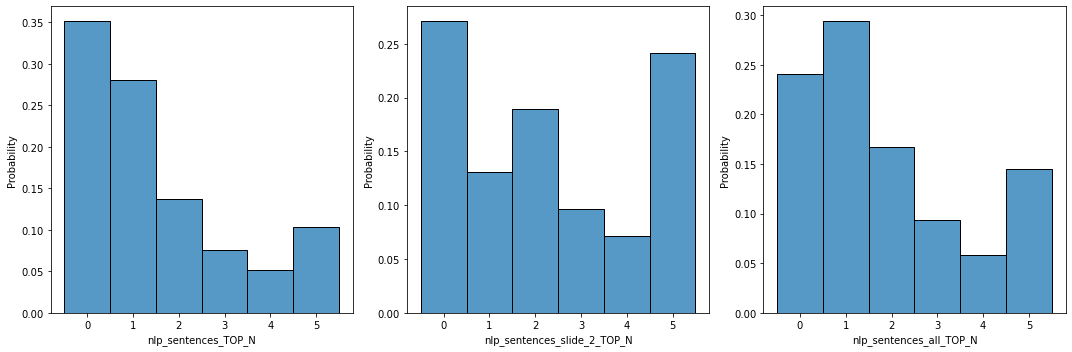

In [15]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

sns.histplot(
    textual_entailment_df.nlp_sentences_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
    ax=ax[0], stat='probability', discrete=True
)
sns.histplot(
    textual_entailment_df.nlp_sentences_slide_2_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
    ax=ax[1], stat='probability', discrete=True
)
sns.histplot(
    textual_entailment_df.nlp_sentences_all_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
    ax=ax[2], stat='probability', discrete=True
)

plt.tight_layout()
plt.show()

# We see the majority of claims (between 65% and 75%) have at least one sentence selected as relevant.
# Let's get the all_TOP_N percentage of non-zeroes per netloc

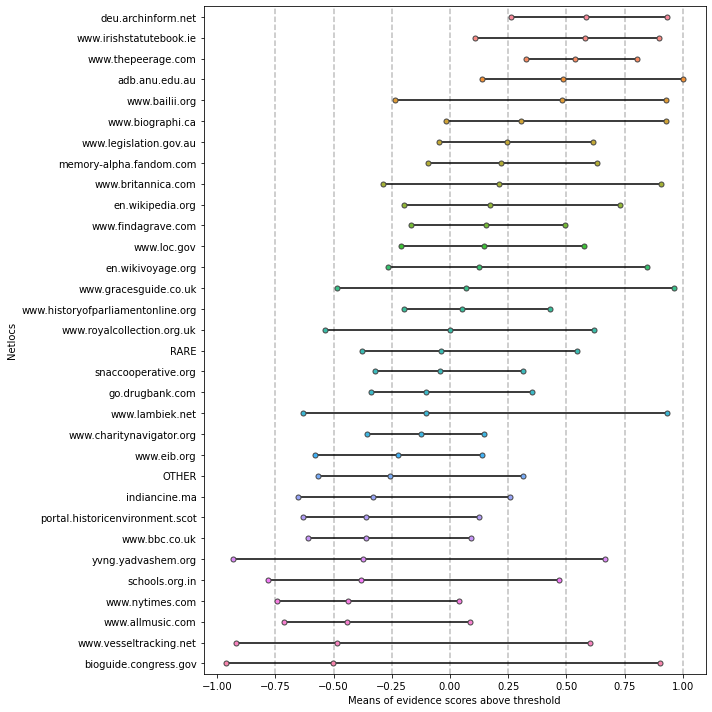

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = textual_entailment_df[['netloc_agg', 'nlp_sentences_all_TOP_N']].copy()
bad_netloc_aggs = [
    'witches.shca.ed.ac.uk','en.isabart.org','bechdeltest.com','npg.si.edu','www.guidetopharmacology.org',
    'letterboxd.com','www.discogs.com','vocab.getty.edu','www.isfdb.org', 'www.npg.org.uk',
    'art.nationalgalleries.org', 'www.tate.org.uk' ,'www.getty.edu', 'memory-beta.fandom.com', 'www.disease-ontology.org',
    'artgallery.yale.edu', 'www.imdb.com', 'muckrack.com', 'live.dbpedia.org', 'dbpedia.org'
]
df = df[~df.netloc_agg.isin(bad_netloc_aggs)]

df['nlp_sentences_all_TOP_N_score_mean'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.mean([xx['score'] for xx in x] if len(x) > 0 else 0)
)
df['nlp_sentences_all_TOP_N_score_max'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.max([xx['score'] for xx in x] if len(x) > 0 else 0)
)
df['nlp_sentences_all_TOP_N_score_min'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.min([xx['score'] for xx in x] if len(x) > 0 else 0)
)
df = df.groupby('netloc_agg').mean().reset_index()
df = df.sort_values('nlp_sentences_all_TOP_N_score_mean', ascending=False).reset_index(drop=True)

for i, row in df.iterrows():
    plt.hlines(
        y=i,
        xmin=row['nlp_sentences_all_TOP_N_score_min'],
        xmax=row['nlp_sentences_all_TOP_N_score_max'],
        color='black'
    )

sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_mean',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)
sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_max',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)
sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_min',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)

plt.axvline(x=1.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.25, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.25, c='black', ls='--', alpha=0.25)

plt.ylabel('Netlocs')
plt.xlabel('Means of evidence scores above threshold')

plt.tight_layout()
plt.show()
# generate a version of this without bad netlocs

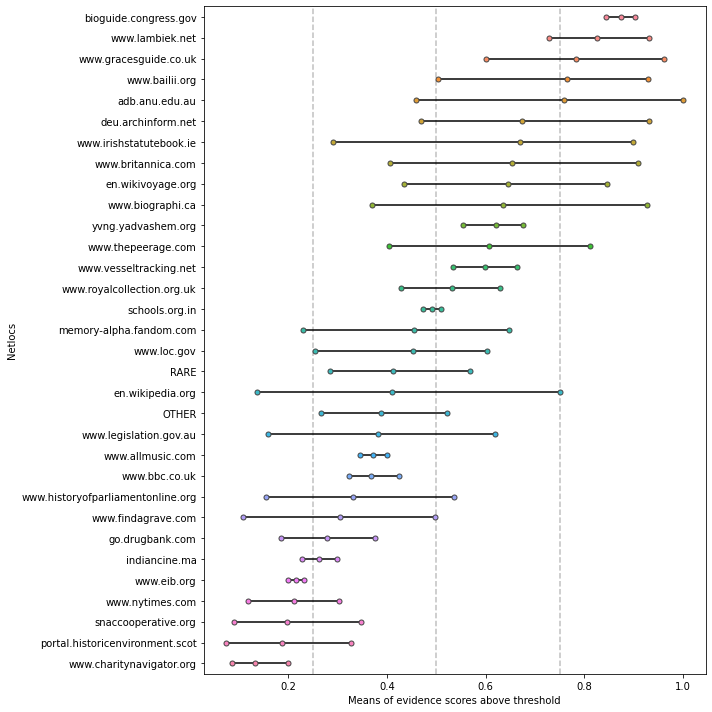

In [86]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = textual_entailment_df[['netloc_agg', 'nlp_sentences_all_TOP_N']].copy()
bad_netloc_aggs = [
    'witches.shca.ed.ac.uk','en.isabart.org','bechdeltest.com','npg.si.edu','www.guidetopharmacology.org',
    'letterboxd.com','www.discogs.com','vocab.getty.edu','www.isfdb.org', 'www.npg.org.uk',
    'art.nationalgalleries.org', 'www.tate.org.uk' ,'www.getty.edu', 'memory-beta.fandom.com', 'www.disease-ontology.org',
    'artgallery.yale.edu', 'www.imdb.com', 'muckrack.com', 'live.dbpedia.org', 'dbpedia.org'
]
df = df[~df.netloc_agg.isin(bad_netloc_aggs)]
df['nlp_sentences_all_TOP_N_score_mean'] = df.nlp_sentences_all_TOP_N\
    .apply(lambda x : [xx for xx in x if xx['score'] > SCORE_THRESHOLD])\
    .apply(
        lambda x : np.mean([xx['score'] for xx in x] if len(x) > 0 else 0)
    )

df['nlp_sentences_all_TOP_N_score_max'] = df.nlp_sentences_all_TOP_N\
    .apply(lambda x : [xx for xx in x if xx['score'] > SCORE_THRESHOLD])\
    .apply(
        lambda x : np.max([xx['score'] for xx in x] if len(x) > 0 else 0)
    )

df['nlp_sentences_all_TOP_N_score_min'] = df.nlp_sentences_all_TOP_N\
    .apply(lambda x : [xx for xx in x if xx['score'] > SCORE_THRESHOLD])\
    .apply(
        lambda x : np.min([xx['score'] for xx in x] if len(x) > 0 else 0)
    )

df = df.groupby('netloc_agg').mean().reset_index()
df = df.sort_values('nlp_sentences_all_TOP_N_score_mean', ascending=False).reset_index(drop=True)

for i, row in df.iterrows():
    plt.hlines(
        y=i,
        xmin=row['nlp_sentences_all_TOP_N_score_min'],
        xmax=row['nlp_sentences_all_TOP_N_score_max'],
        color='black'
    )

sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_mean',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)
sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_max',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)
sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_min',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)

plt.axvline(x=0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.25, c='black', ls='--', alpha=0.25)

plt.ylabel('Netlocs')
plt.xlabel('Means of evidence scores above threshold')

plt.tight_layout()
plt.show()

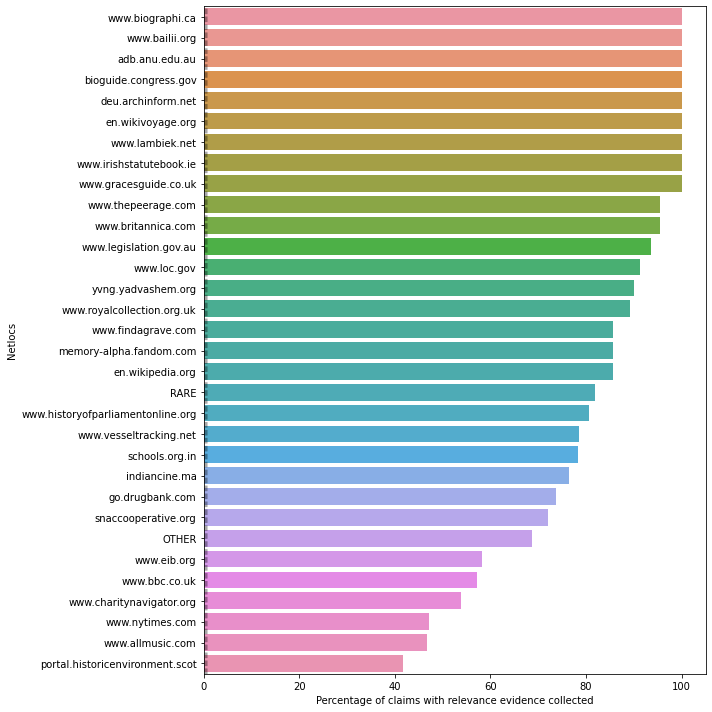

In [87]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = textual_entailment_df[['netloc_agg', 'nlp_sentences_all_TOP_N']].copy()
bad_netloc_aggs = [
    'witches.shca.ed.ac.uk','en.isabart.org','bechdeltest.com','npg.si.edu','www.guidetopharmacology.org',
    'letterboxd.com','www.discogs.com','vocab.getty.edu','www.isfdb.org', 'www.npg.org.uk',
    'art.nationalgalleries.org', 'www.tate.org.uk' ,'www.getty.edu', 'memory-beta.fandom.com', 'www.disease-ontology.org',
    'artgallery.yale.edu', 'www.imdb.com', 'muckrack.com', 'live.dbpedia.org', 'dbpedia.org'
]
df = df[~df.netloc_agg.isin(bad_netloc_aggs)]
df['nlp_sentences_all_TOP_N_nonzero'] = df.nlp_sentences_all_TOP_N\
    .apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD]) != 0)
df['count'] = 1
df = df.groupby('netloc_agg').sum().reset_index()
df['nlp_sentences_all_TOP_N_nonzero_perc'] = 100 * df['nlp_sentences_all_TOP_N_nonzero'] / df['count']
sns.barplot(
    data=df,
    x='nlp_sentences_all_TOP_N_nonzero_perc',
    y='netloc_agg',
    order=df.sort_values('nlp_sentences_all_TOP_N_nonzero_perc', ascending=False).netloc_agg,
    orient='h',
    ax=ax
)

plt.axvline(x=0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.25, c='black', ls='--', alpha=0.25)

plt.ylabel('Netlocs')
plt.xlabel('Percentage of claims with relevance evidence collected')

plt.tight_layout()
plt.show()

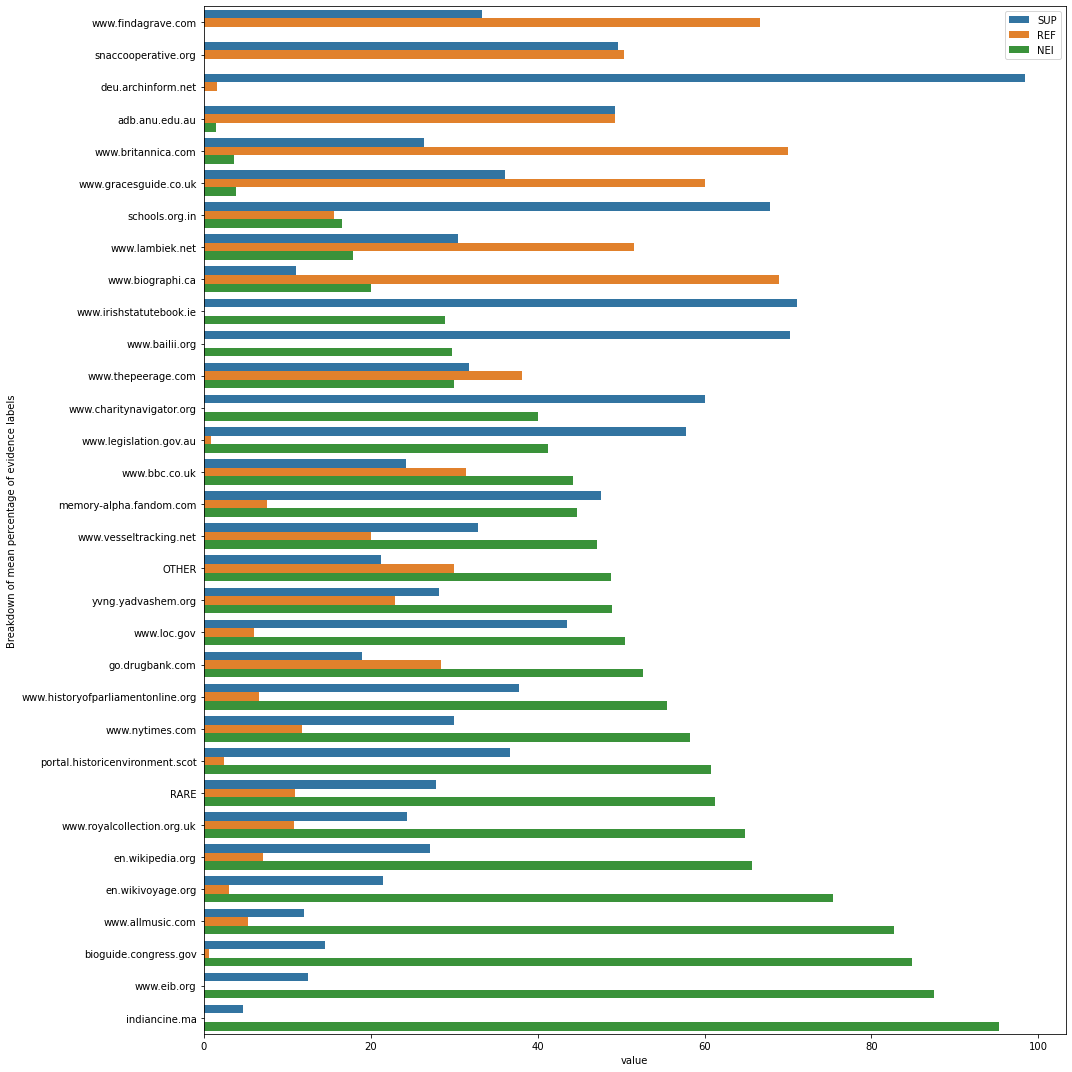

In [17]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

df = textual_entailment_df[['netloc_agg', 'evidence_TE_labels_all_TOP_N']].copy()
bad_netloc_aggs = [
    'witches.shca.ed.ac.uk','en.isabart.org','bechdeltest.com','npg.si.edu','www.guidetopharmacology.org',
    'letterboxd.com','www.discogs.com','vocab.getty.edu','www.isfdb.org', 'www.npg.org.uk',
    'art.nationalgalleries.org', 'www.tate.org.uk' ,'www.getty.edu', 'memory-beta.fandom.com', 'www.disease-ontology.org',
    'artgallery.yale.edu', 'www.imdb.com', 'muckrack.com', 'live.dbpedia.org', 'dbpedia.org'
]
df = df[~df.netloc_agg.isin(bad_netloc_aggs)]
df['evidence_TE_labels_all_TOP_N_SUP_perc'] = df.evidence_TE_labels_all_TOP_N.apply(
    lambda x : 100*len([xx for xx in x if xx == 'SUPPORTS'])/len(x) if x is not None else 0
)
df['evidence_TE_labels_all_TOP_N_REF_perc'] = df.evidence_TE_labels_all_TOP_N.apply(
    lambda x : 100*len([xx for xx in x if xx == 'REFUTES'])/len(x) if x is not None else 0
)
df['evidence_TE_labels_all_TOP_N_NEI_perc'] = df.evidence_TE_labels_all_TOP_N.apply(
    lambda x : 100*len([xx for xx in x if xx == 'NOT ENOUGH INFO'])/len(x) if x is not None else 0
)
df = df.groupby('netloc_agg').mean().reset_index()
df = df.sort_values('evidence_TE_labels_all_TOP_N_NEI_perc', ascending=True).reset_index(drop=True)
df_m = df.melt(id_vars='netloc_agg')

sns.barplot(
    data=df_m,
    x='value',
    y='netloc_agg',
    hue='variable',
    order=df.netloc_agg,
    ax=ax
)

h, l = ax.get_legend_handles_labels()
ax.legend(h, ['SUP','REF','NEI'])

plt.ylabel('Netlocs')
plt.ylabel('Breakdown of mean percentage of evidence labels')

plt.tight_layout()
plt.show()

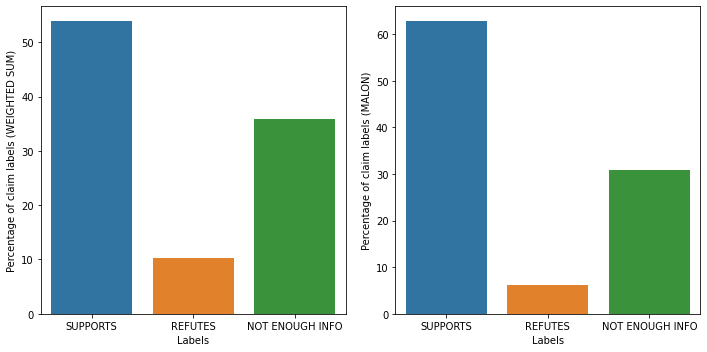

In [91]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

df = textual_entailment_df.copy()
bad_netloc_aggs = [
    'witches.shca.ed.ac.uk','en.isabart.org','bechdeltest.com','npg.si.edu','www.guidetopharmacology.org',
    'letterboxd.com','www.discogs.com','vocab.getty.edu','www.isfdb.org', 'www.npg.org.uk',
    'art.nationalgalleries.org', 'www.tate.org.uk' ,'www.getty.edu', 'memory-beta.fandom.com', 'www.disease-ontology.org',
    'artgallery.yale.edu', 'www.imdb.com', 'muckrack.com', 'live.dbpedia.org', 'dbpedia.org'
]
df = df[~df.netloc_agg.isin(bad_netloc_aggs)]

sns.barplot(
    data=(df.claim_TE_label_weighted_sum_all_TOP_N.value_counts(normalize=True)*100).reset_index(),
    x='index',
    y='claim_TE_label_weighted_sum_all_TOP_N',
    ax=ax[0],
    order=['SUPPORTS','REFUTES','NOT ENOUGH INFO']
)

sns.barplot(
    data=(df.claim_TE_label_malon_all_TOP_N.value_counts(normalize=True)*100).reset_index(),
    x='index',
    y='claim_TE_label_malon_all_TOP_N',
    ax=ax[1],
    order=['SUPPORTS','REFUTES','NOT ENOUGH INFO']
)

ax[0].set(ylabel='Percentage of claim labels (WEIGHTED SUM)', xlabel='Labels')
ax[1].set(ylabel='Percentage of claim labels (MALON)', xlabel='Labels')

plt.tight_layout()
plt.show()

## Manual analysis of selected sentences PLUS textual entailment
In addition to quantitative metrics at this step, let's try just looking at some examples by hand.

We will, for all netloc_aggs, choose a random sample and check if selected evidence make sense given claim.

**Notes**:
- The Weighted Sum method provides a better distinction between Refutes and Supports (especifically, it reduces classifying true REFUTE as false SUPPORT from 0.12 to 0.6), but has a harder time with NOT ENOUGH INFO.
- The Malon method is the opposite, provides a better distinction between NOT ENOUGH INFO and the other two, but has a higher chance of classifying ture REFUTE as false SUPPORT.
- *We should come with a method that mixes both*, as weighted sum considers the evidence scores while malon does not. Perhaps modifying Malon's in a way to consider the positive evidence scores.
- Utilising negative evidence scores is not something we do now. So, when it comes to R3 of showing negatively scored evidence, we might have to think on a way to incorporate them in the final label.
- Past comments on the manual analysis of selected sentences all fit here.

- In some cases, TE will UNLIKELY rate a pair as NEI if the evidence sentence is long. This is because often the TE module will fix favourable (S or R) attention to parts of the information that are not necessarity pertinent to the subject.
    - "Noel Short died in 2001", for example. The evidences repeatedly talk about 2001 and Short, and in dying and Short, but not all three together. This moves the labels away from NEI, as these sentences are relevant, but not in the exact combination of information that only by imbuing the module with common sense it would be able to spot (like when talking about his wife dying through 'she', the module should know 'she' could not possibly mean Short). In other sentence, it mentions "Sir Noel Short" ... "who has died" ... "in the 1970s", which leads to a REFUTES label, as this long sentence spans lots of information that fool the module.
- This might also be an issue when the subject is information-heavy, as the object might get overlooked. Some of these are "solved" because they receive very low evidence scores too.
    - In the "The former wash house, Blackness Castle, is located in the administrative territorial entity of Falkirk.", the evidence "Address/Name of Site. Former barracks block including outbuildings and yard walls to rear and wash house to northeast, excluding custodian's cottage to northeast and scheduled monument SM90036, Blackness Castle, Blackness LB52456." is assigned as SUPPORTS as it cites "former", "wash house", "Blackness Castle", and location names such as "Address of site".
    - Same with "Tetradrachm of Elagabalus, Emperor of Rome, from Antioch, Yale University Art Gallery, inv. 1938.6000.104 is an example of an archaeological artifact." and the evidence "Tetradrachm of Elagabalus, Emperor of Rome from Antioch."
    - Same with "The Restrictive Trade Practices (Jewellery, Watches and Clocks) Order, 1968 applies to the jurisdiction of Ireland."
- A similar issue happens when the subject/object is information-heavy on the claim but abbreviated on the evidence.
    - Like "administrative territorial entity of Anaheim" becoming just "Anaheim".
- Obviously there are issues when whatever is said on the sentence needs some common sense/knowledge to conclude the claim. Like in the "The former wash house, Blackness Castle, is located in the administrative territorial entity of Falkirk." case, the evidence saying
    - For instance, "A Rocky Shore, with the Tour de Croy in the Distance is located in Tate." is true because the link leads to the Tate website with the art piece on it, not because it particularly says so in its text.
    - "Naravoor Lps is located in India." needs knowledge that Kannur is in India.
- Rare ways of writing information throws the modules out
    - Like "Deathdate" instead of "Death date", on 'Alec Waugh died on 03/09/1981.' with evidence "Birthdate: 8 July 1898. Death date: 3 September 1981."

To alter before crowdsourcing:
- **Remember** to alter the URLs leading to paywall-protected pages by using their https://archive.ph/ version.
    - You can build a list by checking if 'archive.ph' is in the html.
- A handful of websites are not in English, we can get a list from netloc archinform.net.

In [37]:
textual_entailment_df.head()

,reference_id,claim_id,final_verbalisation,sampling_weight,final_url,netloc_agg,nlp_sentences,nlp_sentences_slide_2,nlp_sentences_scores,nlp_sentences_slide_2_scores,...,evidence_TE_labels_slide_2_TOP_N,claim_TE_prob_weighted_sum_slide_2_TOP_N,claim_TE_label_weighted_sum_slide_2_TOP_N,claim_TE_label_malon_slide_2_TOP_N,evidence_TE_prob_all_TOP_N,evidence_TE_prob_weighted_all_TOP_N,evidence_TE_labels_all_TOP_N,claim_TE_prob_weighted_sum_all_TOP_N,claim_TE_label_weighted_sum_all_TOP_N,claim_TE_label_malon_all_TOP_N
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,24749.538462,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop...","[-0.9059305191, -0.9998914599000001, -0.999842...","[-0.9975231290000001, -0.9998638630000001, -0....",...,"[SUPPORTS, SUPPORTS, SUPPORTS, NOT ENOUGH INFO...","[3.5341536999, 0.048523321700000004, 1.3833616...",SUPPORTS,SUPPORTS,"[[0.9708649516000001, 0.0061447304, 0.02299031...","[[0.9707732797, 0.0061441502, 0.0229881462], [...","[SUPPORTS, SUPPORTS, SUPPORTS, SUPPORTS, NOT E...","[3.889308691, 0.0454286449, 1.0620666742]",SUPPORTS,SUPPORTS
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,24749.538462,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc...","[-0.9904284477, -0.9997430444000001, -0.999761...","[-0.9976871014, -0.9997031689, -0.999774158, -...",...,"[SUPPORTS, NOT ENOUGH INFO, NOT ENOUGH INFO, N...","[0.5767840743, 0.31985166670000004, 0.70817500...",NOT ENOUGH INFO,SUPPORTS,"[[0.09385417400000001, 0.2980020344, 0.6081437...","[[0.0830457285, 0.2636834979, 0.5381085873], [...","[NOT ENOUGH INFO, SUPPORTS, NOT ENOUGH INFO, N...","[0.6590975523, 0.6129509211, 1.2033489943]",NOT ENOUGH INFO,SUPPORTS
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,The Average White Band was formed in Dundee.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9992159009, -0.9998582602, -0.999841928500...","[-0.9997091293, -0.999826014, -0.9998285174, -...",...,"[NOT ENOUGH INFO, REFUTES, NOT ENOUGH INFO, NO...","[0.0077750389000000005, 1.0016101599, 0.943389...",REFUTES,REFUTES,"[[0.0031622618000000003, 0.6379567385, 0.35888...","[[0.0031315740000000002, 0.6317657828000001, 0...","[REFUTES, NOT ENOUGH INFO, REFUTES, NOT ENOUGH...","[0.011158074300000001, 1.6352716684000002, 1.3...",REFUTES,REFUTES
3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band started in 1972.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9852669835000001, -0.9997751117, -0.999563...","[-0.9655147195, -0.9992546439000001, -0.999627...",...,"[SUPPORTS, REFUTES, REFUTES, SUPPORTS, NOT ENO...","[1.5369269848, 1.0780794621, 0.5463495255]",SUPPORTS,SUPPORTS,"[[0.9388607144000001, 0.0051775482, 0.05596167...","[[0.9337435365000001, 0.0051493281, 0.05565666...","[SUPPORTS, SUPPORTS, REFUTES, REFUTES, REFUTES]","[1.9153820276, 1.9608505964, 0.5913071632]",REFUTES,SUPPORTS
4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi began work in 1983.,24749.538462,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the...","[-0.9987268448000001, -0.9997874498, -0.999821...","[-0.9918303490000001, -0.9996852875000001, -0....",...,"[SUPP

In [92]:
df = textual_entailment_df.copy()
bad_netloc_aggs = [
    'witches.shca.ed.ac.uk','en.isabart.org','bechdeltest.com','npg.si.edu','www.guidetopharmacology.org',
    'letterboxd.com','www.discogs.com','vocab.getty.edu','www.isfdb.org', 'www.npg.org.uk',
    'art.nationalgalleries.org', 'www.tate.org.uk' ,'www.getty.edu', 'memory-beta.fandom.com', 'www.disease-ontology.org',
    'artgallery.yale.edu', 'www.imdb.com', 'muckrack.com', 'live.dbpedia.org', 'dbpedia.org'
]
df = df[~df.netloc_agg.isin(bad_netloc_aggs)]
try:
    for netloc in df.netloc_agg.unique().tolist():
        print('-'*10)
        print(netloc,'\n')
        sampled_rows = df[df['netloc_agg'] == netloc].sample(3, random_state=42)
        for i, row in sampled_rows.iterrows():
            print(
                '->', row['final_verbalisation'],'\n',
                '\t-WS:', row['claim_TE_label_weighted_sum_all_TOP_N'], f"({row['claim_TE_prob_weighted_sum_all_TOP_N']})\n",
                '\t-M: ', row['claim_TE_label_malon_all_TOP_N']
            )
            print('->>', row['final_url'])
            for i, sentence in enumerate(row['nlp_sentences_all_TOP_N']):
                if sentence['score'] > SCORE_THRESHOLD:
                    print(
                        f"\t{i+1}. {sentence['sentence']}\n",
                        f"\t-Evidence Score: {sentence['score']}\n",
                        f"\t-Label Prob: {row['evidence_TE_prob_all_TOP_N'][i]}\n",
                        f"\t-Label Prob Weighted: {row['evidence_TE_prob_weighted_all_TOP_N'][i]}\n",
                        f"\t-Label: {row['evidence_TE_labels_all_TOP_N'][i]}\n",
                    )
                else:
                    print(
                        f"\t{i+1}. {sentence['sentence']}\n",
                        f"\t-Evidence Score: {sentence['score']}\n",
                        f"\t-Label Prob: {row['evidence_TE_prob_all_TOP_N'][i]}\n",
                        f"\t-Label Prob Weighted: {[0,0,0]}\n",
                        f"\t-Label: {row['evidence_TE_labels_all_TOP_N'][i]}\n",
                    )
            print()
except Exception:
    print(row)
    raise

----------
en.wikipedia.org 

-> Vidyasagar is a performer of Ponniyin Selvan. 
 	-WS: SUPPORTS ([0.7143831253, 0.010819014200000001, 0.1471280009])
 	-M:  SUPPORTS
->> https://en.wikipedia.org/w/index.php?title=Ponniyin_Selvan_(2005_film)&oldid=982538956
	1. Ponniyin Selvan (English: The son of Ponni) is a 2005 Indian Tamil drama film written and directed by Radha Mohan. Produced by A. M. Ratnam, it stars his son Ravi Krishna, along with Gopika and Revathi in the lead roles, while Vidyasagar had composed the music for the film.
 	-Evidence Score: 0.7061274648
 	-Label Prob: [0.8254368305, 0.013923050800000001, 0.1606400758]
 	-Label Prob Weighted: [0.5828636289, 0.009831449, 0.1134323701]
 	-Label: SUPPORTS

	2. Azhagiya Theeye (2004) Ponniyin Selvan (2005) Mozhi (2007) Abhiyum Naanum (2008)
 	-Evidence Score: 0.16620272400000002
 	-Label Prob: [0.7913199067000001, 0.0059419302, 0.20273816590000002]
 	-Label Prob Weighted: [0.13151952620000001, 0.0009875650000000001, 0.0336956345]
 	-

-> The Military Academy is a drama film. 
 	-WS: NOT ENOUGH INFO ([0, 0, 0])
 	-M:  NOT ENOUGH INFO
->> https://www.nytimes.com/reviews/movies
	1. The movie is indebted to neon-lit crime thrillers set behind the wheel of an outlaw’s automobile, but it fails to deliver the goods. By Calum Marsh March 3, 2022 Read Review Find tickets After Yang PG Drama, Sci-Fi Directed by Kogonada Colin Farrell plays a father who tries to repair the family’s caretaker-android in a science-fiction tale about what it means to be human.
 	-Evidence Score: -0.7050267458
 	-Label Prob: [0.5959047079, 0.012104092200000001, 0.39199125770000004]
 	-Label Prob Weighted: [0, 0, 0]
 	-Label: SUPPORTS

	2. In this moving period drama, a German gay man repeatedly declares his independence in a country that criminalizes his desire and his identity. By Manohla Dargis March 3, 2022 Read Review Find tickets Fresh NYT Critic’s Pick R Comedy, Horror, Thriller Directed by Mimi Cave Daisy Edgar-Jones and Sebastian Stan star